In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import community as community_louvain
import igraph as ig
import leidenalg as la
import networkit as nk
# import sha3
from datetime import datetime
from venn import venn
from scipy.stats import pearsonr, spearmanr
from collections import Counter

In [ ]:
# keccak = sha3.keccak_256()
# keccak.update(b"DelegateChanged(address,address,uint8)")
# keccak.update(b"DelegatedPowerChanged(address,uint256,uint8)")
# keccak.update(b"Transfer(address,address,uint256)")
# print(keccak.hexdigest())

In [2]:
plt.rcdefaults()

## Data preparation

In [3]:
transfers_df = pd.read_csv('data/1_year/reduced_transfers_1_year.csv')

with open('data/proposals/aave/aave_v2_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_proposals = json.load(file)['data']['proposals']
with open('data/proposals/aave/aave_v3_on_chain_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_proposals = json.load(file)['data']['proposals']
with open('data/proposals/aave/aave_snapshot_proposals_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_proposals = json.load(file)['data']['proposals']
    
with open('data/proposals/aave/aave_v2_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v2_votes = json.load(file)
with open('data/proposals/aave/aave_v3_on_chain_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_v3_votes = json.load(file)
with open('data/proposals/aave/aave_snapshot_votes_1_year.json', 'r', encoding='utf8') as file:
    aave_snapshot_votes = json.load(file)
    
with open('data/proposals/aave/aave_delegations.json', 'r', encoding='utf8') as file:
    delegations = json.load(file)
    
delegations = [
    entry for entry in delegations
    if 1696118399 < entry.get('timestamp', 0) < 1727740800
]

In [ ]:
AAVE_tokens = ['AAVE', 'PolAAVE', 'ArbAAVE']
aTokens = ['aEthWETH', 'aPolWETH', 'aArbWETH'] #, 'aEthUSDT', 'aEthUSDC', 'aPolUSDC', 'aPolUSDT', 'aArbUSDC', 'aArbUSDT']

aave_df = transfers_df[transfers_df['token'].isin(AAVE_tokens)]
aToken_df = transfers_df[transfers_df['token'].isin(aTokens)]

## Network construction

In [ ]:
G_nk = nk.Graph(weighted=True)

node_map = {}
edge_data = {}

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address not in node_map:
        node_map[from_address] = G_nk.addNode()
    if to_address not in node_map:
        node_map[to_address] = G_nk.addNode()
        
    from_node = node_map[from_address]
    to_node = node_map[to_address]
    
    edge_id = (from_node, to_node)
    
    if edge_id in edge_data:
        edge_data[edge_id]['total_volume'] += value
        edge_data[edge_id]['num_transfers'] += 1
    else:
        edge_data[edge_id] = {'total_volume': value, 'num_transfers': 1}

for (from_node, to_node), data in edge_data.items():
    G_nk.addEdge(from_node, to_node, w=data['total_volume'])
    # G_nk.setWeight(from_node, to_node, data['total_volume'])
    # G_nk.setEdgeValue(from_node, to_node, data['num_transfers'])

In [26]:
nk.overview(G_nk)

Network Properties:
nodes, edges			189402, 362545
directed?			False
weighted?			True
isolated nodes			0
self-loops			316
density				0.000020
min/max/avg degree		1, 18914, 3.826644
degree assortativity		-0.118308
number of connected components	5993
size of largest component	176735 (93.31 %)


In [5]:
G_aave = nx.MultiDiGraph()

for _, row in aave_df.iterrows():
    G_aave.add_edge(row['from'].lower(), row['to'].lower(), key=row['timestamp'], weight=row['value'])
    
G_aave_nodes = G_aave.nodes()

In [6]:
G_aave_undirected = nx.Graph()

for _, row in aave_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aave_undirected.has_edge(from_address, to_address):
        G_aave_undirected[from_address][to_address]['weight'] += value
    else:
        G_aave_undirected.add_edge(from_address, to_address, weight=value)

G_aave_nodes = G_aave_undirected.nodes()

In [ ]:
G_aToken = nx.MultiDiGraph()

for _, row in aToken_df.iterrows():
    G_aToken.add_edge(row['from'].lower(), row['to'].lower(), key=row['timestamp'], weight=row['value'], token=row['token'])
    
G_aToken_nodes = G_aToken.nodes()

In [ ]:
G_aToken_undirected = nx.Graph()

for _, row in aToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_aToken_undirected.has_edge(from_address, to_address):
        G_aToken_undirected[from_address][to_address]['weight'] += value
    else:
        G_aToken_undirected.add_edge(from_address, to_address, weight=value)

In [8]:
# proposal_counts = {}
# for proposal in aave_v2_proposals:
#     proposer = proposal['user']['id']
#     if proposer in proposal_counts:
#         proposal_counts[proposer] += 1
#     else:
#         proposal_counts[proposer] = 1

# for proposal in aave_v3_proposals:
#     proposer = proposal['creator']
#     if proposer in proposal_counts:
#         proposal_counts[proposer] += 1
#     else:
#         proposal_counts[proposer] = 1

vote_counts = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1

for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1
            
vote_weights = {}
for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
delegation_counts = {}
from_delegations = {}
to_delegations = {}

for delegation in delegations:
    delegator = delegation['from'].lower()
    if delegator in delegation_counts:
        delegation_counts[delegator] += 1
    else:
        delegation_counts[delegator] = 1
        
    if delegator in from_delegations:
        from_delegations[delegator] += 1
    else:
        from_delegations[delegator] = 1
                
    delegate = delegation['to'].lower()
    if delegate in delegation_counts:
        delegation_counts[delegate] += 1
    else: 
        delegation_counts[delegate] = 1
        
    if delegate in to_delegations:
        to_delegations[delegate] += 1
    else:
        to_delegations[delegate] = 1
        
# for node in G_aave.nodes():
#     # G_aave.nodes[node]['proposals'] = proposal_counts.get(node, 0)
#     G_aave.nodes[node]['votes'] = vote_counts.get(node, 0)
#     G_aave.nodes[node]['delegations'] = delegation_counts.get(node, 0)
#     G_aave_nodes[node]['from_delegations'] = from_delegations.get(node, 0)
#     G_aave_nodes[node]['to_delegations'] = to_delegations.get(node, 0)

In [ ]:
for voter in vote_weights:
    vote_weights[voter] = vote_weights[voter] / vote_counts[voter]

In [21]:
same_from_to_delegations = [delegation for delegation in delegations if delegation['from'].lower() == delegation['to'].lower()]

print(len(same_from_to_delegations), len(delegations))

1641 4756


In [10]:
v2_proposers = set()
v3_proposers = set()
snapshot_proposers = set()

for proposal in aave_v2_proposals:
    v2_proposers.add(proposal['user']['id'])
for proposal in aave_v3_proposals:
    v3_proposers.add(proposal['creator'])
for proposal in aave_snapshot_proposals:
    snapshot_proposers.add(proposal['author'].lower())
    
proposers = (v2_proposers | v3_proposers | snapshot_proposers) & G_aave_nodes

In [11]:
v2_voters = set()
v3_voters = set()
snapshot_voters = set()

for votes in aave_v2_votes:
    for vote in votes['votes']:
        v2_voters.add(vote['id'].split('-')[0])
            
for votes in aave_v3_votes:
    for vote in votes['votes']:
        v3_voters.add(vote['voter'].lower())

for votes in aave_snapshot_votes:
    for vote in votes['votes']:
        snapshot_voters.add(vote['voter'].lower())
        
voters = (v2_voters | v3_voters | snapshot_voters) & G_aave_nodes

In [12]:
delegators = set()
delegates = set()

from_delegations_without_same_to = set()
to_delegations_without_same_from = set()

for delegate in delegations:
    delegator = delegate['from'].lower()
    delegate = delegate['to'].lower()
    
    delegators.add(delegator)
    delegates.add(delegate)
    
    if delegator != delegate:
        from_delegations_without_same_to.add(delegator)
        to_delegations_without_same_from.add(delegate)    
    
all_delegations = (delegators | delegates) & G_aave_nodes

In [17]:
WETH_users = (set(aToken_df['from'].unique()) | set(aToken_df['to'].unique()))
AAVE_users = (set(aave_df['from'].unique()) | set(aave_df['to'].unique()))
all_governance_users = v2_proposers | v3_proposers | v2_voters | v3_voters | delegators | delegates

In [14]:
non_governance_users = G_aave_nodes - proposers - voters - all_delegations
governance_users = proposers | voters | all_delegations
economic_users = (set(aToken_df['from'].str.lower()) | set(aToken_df['to'].str.lower())) & G_aave_nodes

In [15]:
only_economic_users = economic_users - governance_users
only_governance_users = governance_users - economic_users
both_economic_and_governance_users = economic_users & governance_users

In [10]:
print(f'Total: {len(G_aave_nodes)}\nProposers: {len(proposers)}\nVoters: {len(voters)}\nDelegations: {len(all_delegations)}\nGovernance: {len(governance_users)}\nEconomic: {len(economic_users)}')

Total: 189402
Proposers: 10
Voters: 1885
Delegations: 1155
Governance: 2621
Economic: 14592


## Correlation analysis

<Figure size 1200x600 with 0 Axes>

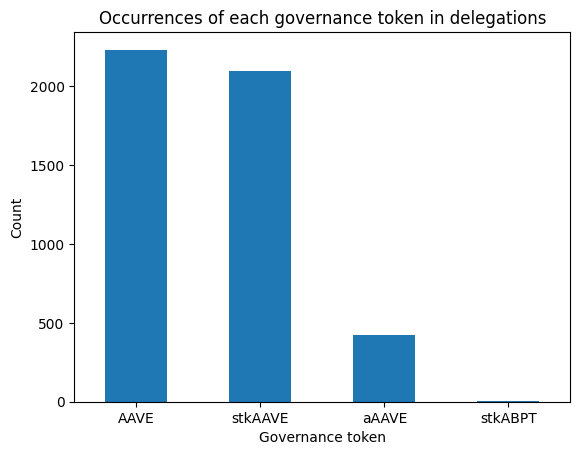

In [43]:
addresses = [entry['address'] for entry in delegations]

address_to_name = {
    '0x7Fc66500c84A76Ad7e9c93437bFc5Ac33E2DDaE9': 'AAVE',
    '0x4da27a545c0c5B758a6BA100e3a049001de870f5': 'stkAAVE',
    '0xA700b4eB416Be35b2911fd5Dee80678ff64fF6C9': 'aAAVE',
    '0xa1116930326D21fB917d5A27F1E9943A9595fb47': 'stkABPT'
}

address_counts = Counter(addresses)

address_counts_df = pd.DataFrame.from_dict(address_counts, orient='index', columns=['count']).reset_index()
address_counts_df = address_counts_df.rename(columns={'index': 'address'})

address_counts_df['address'] = address_counts_df['address'].map(address_to_name).fillna(address_counts_df['address'])

plt.figure(figsize=(12, 6))
address_counts_df.plot(kind='bar', x='address', y='count', legend=False)
plt.xlabel('Governance token')
plt.ylabel('Count')
plt.title('Occurrences of each governance token in delegations')
plt.xticks(rotation=0)
plt.show()

In [ ]:
G_aave_dc = nx.degree_centrality(G_aave)

G_aave_in_dc = nx.in_degree_centrality(G_aave)

G_aave_out_dc = nx.out_degree_centrality(G_aave)

# G_aave_clustering = nx.clustering(G_aave, weight='weight')

G_aave_undirected_clustering = nx.clustering(G_aave_undirected, weight='weight')

G_aave_pr = nx.pagerank(G_aave, weight='weight')

# G_aave_cc = nx.closeness_centrality(G_aave)

# G_aave_undirected_cc = nx.closeness_centrality(G_aave_undirected)
with open('closeness.json', 'r', encoding='utf8') as file:
    G_aave_undirected_closeness = json.load(file)

# G_aave_undirected_bc = nx.betweenness_centrality(G_aave_undirected, weight='weight')

# G_aave_bc = nx.betweenness_centrality(G_aave)

# G_aave_ec = nx.eigenvector_centrality(G_aave)

# G_aave_kc = nx.katz_centrality(G_aave)


G_aToken_undirected_dc = nx.degree_centrality(G_aToken_undirected)

nodes_with_votes = vote_counts.keys()
nodes_with_delegations = delegation_counts.keys()
nodes_with_from_delegations = from_delegations.keys()
nodes_with_to_delegations = to_delegations.keys()
nodes_with_WETH_transfers = 

In [93]:
# x1 = [G_aave_dc[node] for node in nodes_with_votes if node in G_aave_dc]
# y1 = [vote_counts[node] for node in nodes_with_votes if node in G_aave_dc]

# x2 = [G_aave_pr[node] for node in nodes_with_votes if node in G_aave_pr]
# y2 = [vote_counts[node] for node in nodes_with_votes if node in G_aave_pr]

# common_nodes = set(G_aave_dc.keys()) & set(G_aToken_undirected_dc.keys())
# x3 = [G_aave_dc[node] for node in common_nodes]
# y3 = [G_aToken_undirected_dc[node] for node in common_nodes]

# x4 = [delegation_counts[node] for node in nodes_with_delegations if node in nodes_with_votes and node in G_aave_nodes]
# y4 = [vote_counts[node] for node in nodes_with_votes if node in nodes_with_delegations and node in G_aave_nodes]

# x5 = [from_delegations[node] for node in nodes_with_from_delegations if node in nodes_with_votes and node in G_aave_nodes]
# y5 = [vote_counts[node] for node in nodes_with_votes if node in nodes_with_from_delegations and node in G_aave_nodes]

# x6 = [to_delegations[node] for node in nodes_with_to_delegations if node in nodes_with_votes and node in G_aave_nodes]
# y6 = [vote_counts[node] for node in nodes_with_votes if node in nodes_with_to_delegations and node in G_aave_nodes]

# total_incoming_weight = {}
# total_outgoing_weight = {}

# for node in G_aave.nodes():
#     total_incoming_weight[node] = sum(data['weight'] for _, _, data in G_aave.in_edges(node, data=True))
#     total_outgoing_weight[node] = sum(data['weight'] for _, _, data in G_aave.out_edges(node, data=True))

# votes_with_incoming_weight = [(total_incoming_weight[node], vote_counts[node]) for node in vote_counts if node in total_incoming_weight]
# x7, y7 = zip(*votes_with_incoming_weight)

# votes_with_outgoing_weight = [(total_outgoing_weight[node], vote_counts[node]) for node in vote_counts if node in total_outgoing_weight]
# x8, y8 = zip(*votes_with_outgoing_weight)

# degrees = dict(G_aave.degree())
# votes_casted = {node: vote_counts.get(node, 0) for node in G_aave.nodes()}
# votes_degrees_df = pd.DataFrame({
#     'votes_casted': list(votes_casted.values()),
#     'degree': [degrees[node] for node in G_aave.nodes()]
# })
# average_degree_per_votes = votes_degrees_df.groupby('votes_casted')['degree'].mean().reset_index()
# x9 = average_degree_per_votes['votes_casted']
# y9 = average_degree_per_votes['degree']

# votes_weights = {node: vote_weights.get(node, 0) for node in G_aave.nodes()}
# votes_degrees_df = pd.DataFrame({
#     'votes_weights': list(votes_weights.values()),
#     'degree': [degrees[node] for node in G_aave.nodes()]
# })
# average_weight_per_votes = votes_degrees_df.groupby('votes_weights')['degree'].mean().reset_index()
# x10 = average_weight_per_votes['votes_weights']
# y10 = average_weight_per_votes['degree']

WETH_degrees = dict(G_aToken_undirected.degree())
WETH_transfers = {node: WETH_degrees.get(node, 0) for node in G_aave.nodes()}
WETH_degrees_df = pd.DataFrame({
    'WETH_transfers': list(WETH_transfers.values()),
    'degree': [degrees[node] for node in G_aave.nodes()]
})
average_degree_per_transfers = WETH_degrees_df.groupby('WETH_transfers')['degree'].mean().reset_index()
x11 = average_degree_per_transfers['WETH_transfers']
y11 = average_degree_per_transfers['degree']

PearsonRResult(statistic=-0.03249543520584658, pvalue=0.7909585548998415)
SignificanceResult(statistic=0.29846819939315417, pvalue=0.012737269147610697)


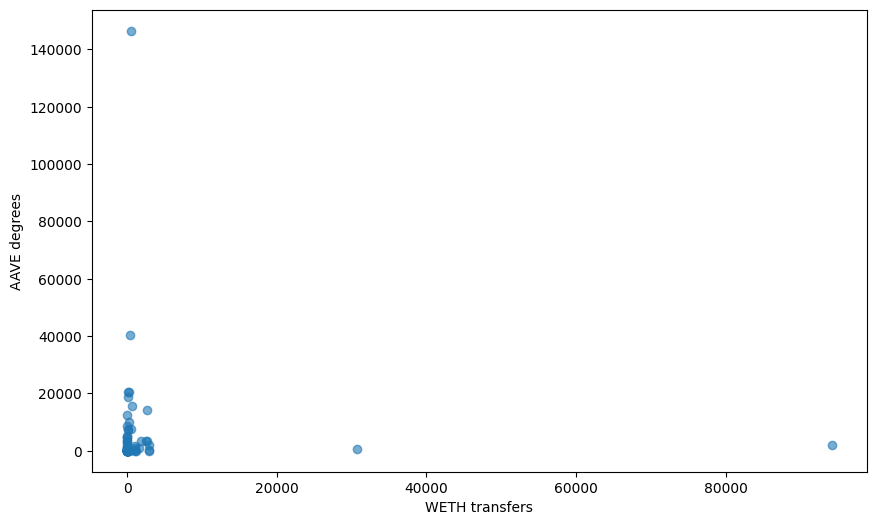

In [96]:
compute_correlation(x11, y11, 'WETH transfers', 'AAVE degrees')

In [95]:
def compute_correlation(x, y, xlabel, ylabel):
    print(pearsonr(x, y))
    print(spearmanr(x, y))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.title('Feature & number of votes')
    plt.show()

In [20]:
def compute_correlation_2(feature_scores, counts, node_subset_1, node_subset_2):
    x_temp = [feature_scores[node] for node in node_subset_1 if node in node_subset_2 and node in G_aave_nodes]
    y_temp = [counts[node] for node in node_subset_2 if node in node_subset_1 and node in G_aave_nodes]
    
    print(pearsonr(x_temp, y_temp))
    print(spearmanr(x_temp, y_temp))
    
    # plt.figure(figsize=(10, 6))
    # plt.scatter(x_temp, y_temp, alpha=0.6)
    # plt.xlabel('Feature')
    # plt.ylabel('Number of votes')
    # plt.title('Feature & number of votes')
    # plt.show()

### NetworKit

In [20]:
degree_centrality_nk = nk.centrality.DegreeCentrality(G_nk)
degree_centrality_nk.run()
degree_centrality_scores_nk = degree_centrality_nk.scores()

node_map_reverse = {v: k for k, v in node_map.items()}

nodes_with_votes_nk = [node_map_reverse[node] for node in vote_counts if node in node_map_reverse]

# x1_nk = [degree_centrality_scores_nk[node_map[node]] for node in nodes_with_votes_nk if node in node_map]
# y_nk = [vote_counts[node] for node in nodes_with_votes_nk if node in node_map]

# plt.figure(figsize=(10, 6))
# plt.scatter(x1_nk, y_nk, alpha=0.6)
# plt.xlabel('Degree centrality')
# plt.ylabel('Number of votes')
# plt.title('Degree centrality & number of votes (G_nk)')
# plt.show()

In [ ]:
betweenness = nk.centrality.Betweenness(G_nk, normalized=True)
betweenness.run()
betweenness_scores = betweenness.scores()

In [ ]:
closeness = nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED)
closeness.run()
closeness_scores = closeness.scores()

In [ ]:
pagerank_nk = nk.centrality.PageRank(G_nk)
pagerank_nk.run()
pagerank_scores_nk = pagerank_nk.scores()

In [ ]:
degree_centrality_nk = nk.centrality.DegreeCentrality(G_nk)
degree_centrality_nk.run()
degree_centrality_scores_nk = degree_centrality_nk.scores()

pagerank_nk = nk.centrality.PageRank(G_nk)
pagerank_nk.run()
pagerank_scores_nk = pagerank_nk.scores()

# Map node IDs back to addresses
node_map_reverse = {v: k for k, v in node_map.items()}

# Extract nodes with votes
nodes_with_votes_nk = [node_map_reverse[node] for node in vote_counts if node in node_map_reverse]

# Prepare data for plotting
x1_nk = [degree_centrality_scores_nk[node_map[node]] for node in nodes_with_votes_nk if node in node_map]
y_nk = [vote_counts[node] for node in nodes_with_votes_nk if node in node_map]

# Plot degree centrality vs number of votes
plt.figure(figsize=(10, 6))
plt.scatter(x1_nk, y_nk, alpha=0.6)
plt.xlabel('Degree centrality')
plt.ylabel('Number of votes')
plt.title('Degree centrality & number of votes (G_nk)')
plt.show()

x2_nk = [pagerank_scores_nk[node_map[node]] for node in nodes_with_votes_nk if node in node_map]

# Plot PageRank vs number of votes
plt.figure(figsize=(10, 6))
plt.scatter(x2_nk, y_nk, alpha=0.6)
plt.xlabel('PageRank')
plt.ylabel('Number of votes')
plt.title('PageRank & number of votes (G_nk)')
plt.show()

## Distributions

### AAVE

C:\Users\Sam\AppData\Local\Temp\ipykernel_3892\173491468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_3892\173491468.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aave_df['date'] = aave_df['date'].dt.date


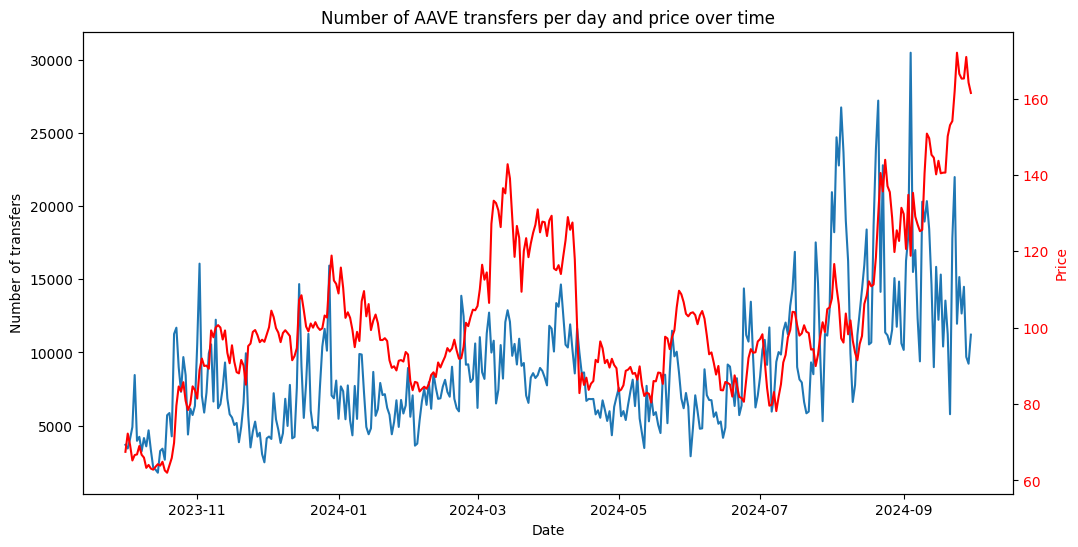

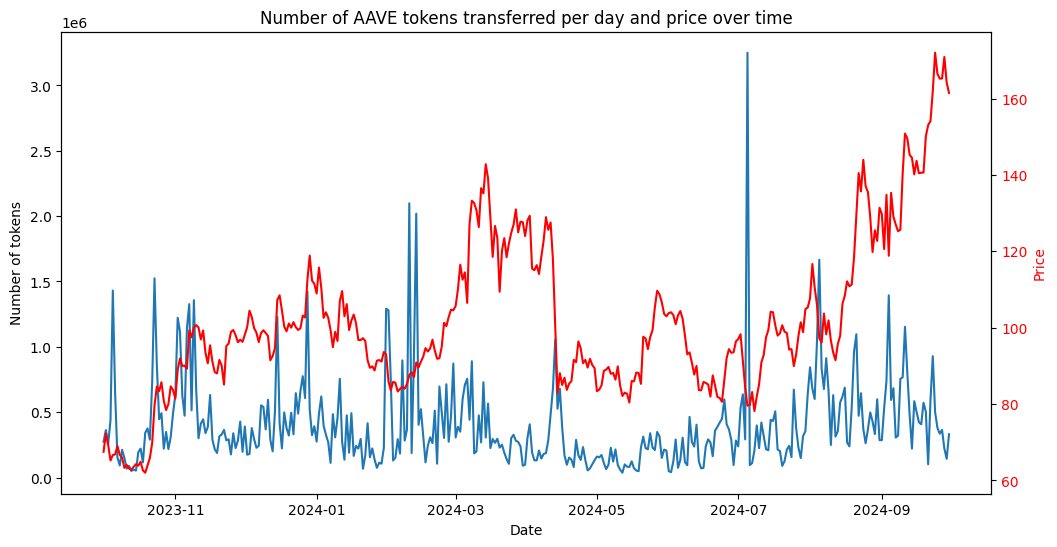

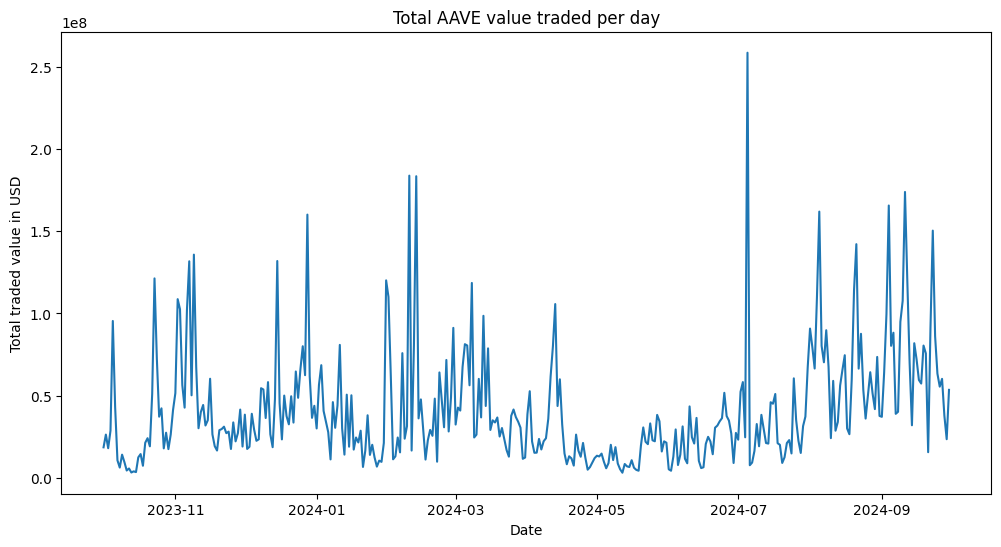

In [ ]:
price_data = pd.read_csv('data/AAVE_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

# aave_df['date'] = pd.to_datetime(aave_df['timestamp'], unit='s')
# aave_df['date'] = aave_df['date'].dt.date
aave_df_filtered = aave_df[aave_df['from'].str.lower() != aave_df['to'].str.lower()]

merged_data_aave = aave_df_filtered.groupby('date').size().reset_index(name='num_entries')
merged_data_aave = aave_df_filtered.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_aave = merged_data_aave.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_aave['total_traded_value'] = merged_data_aave['total_value'] * merged_data_aave['price']

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_aave['date'], merged_data_aave['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
ax2.set_ylabel('Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of AAVE transfers per day and price over time')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_aave['date'], merged_data_aave['total_value'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tokens')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(merged_data_aave['date'], merged_data_aave['price'], color='red')
ax2.set_ylabel('Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of AAVE tokens transferred per day and price over time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_aave['date'], merged_data_aave['total_traded_value'])
plt.xlabel('Date')
plt.ylabel('Total traded value in USD')
plt.title('Total AAVE value traded per day')
plt.show()

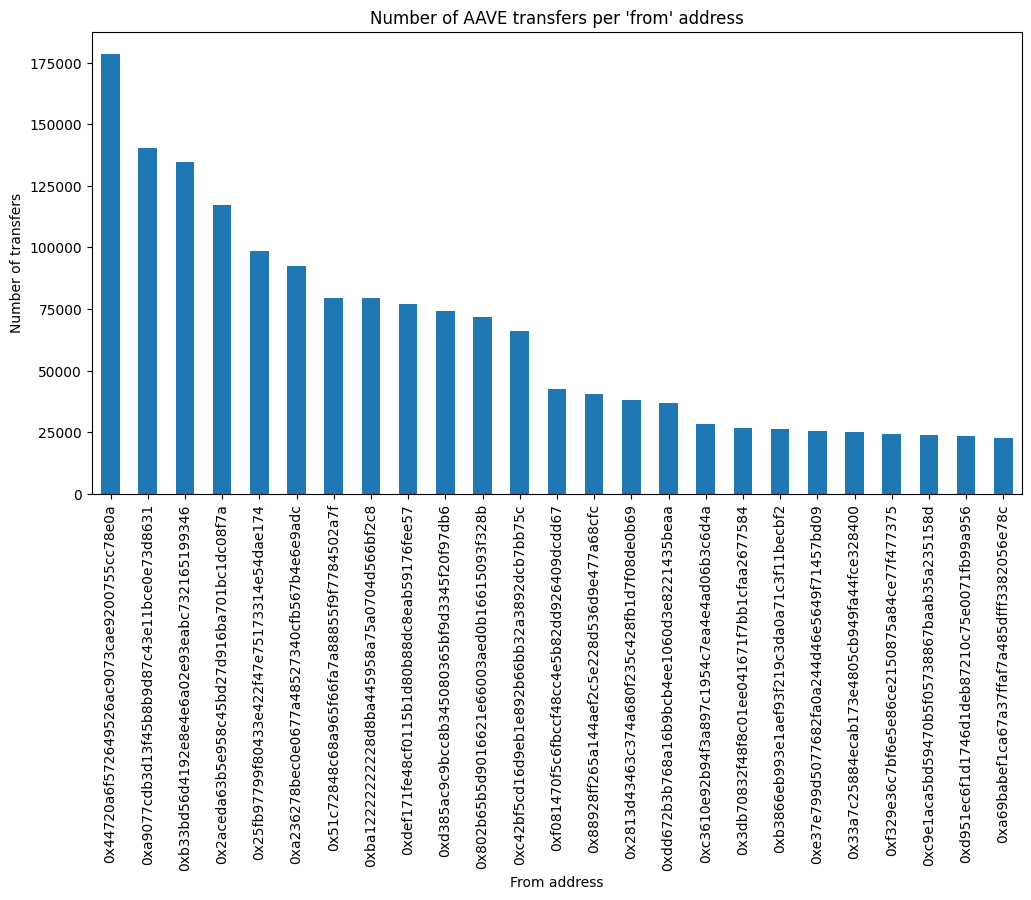

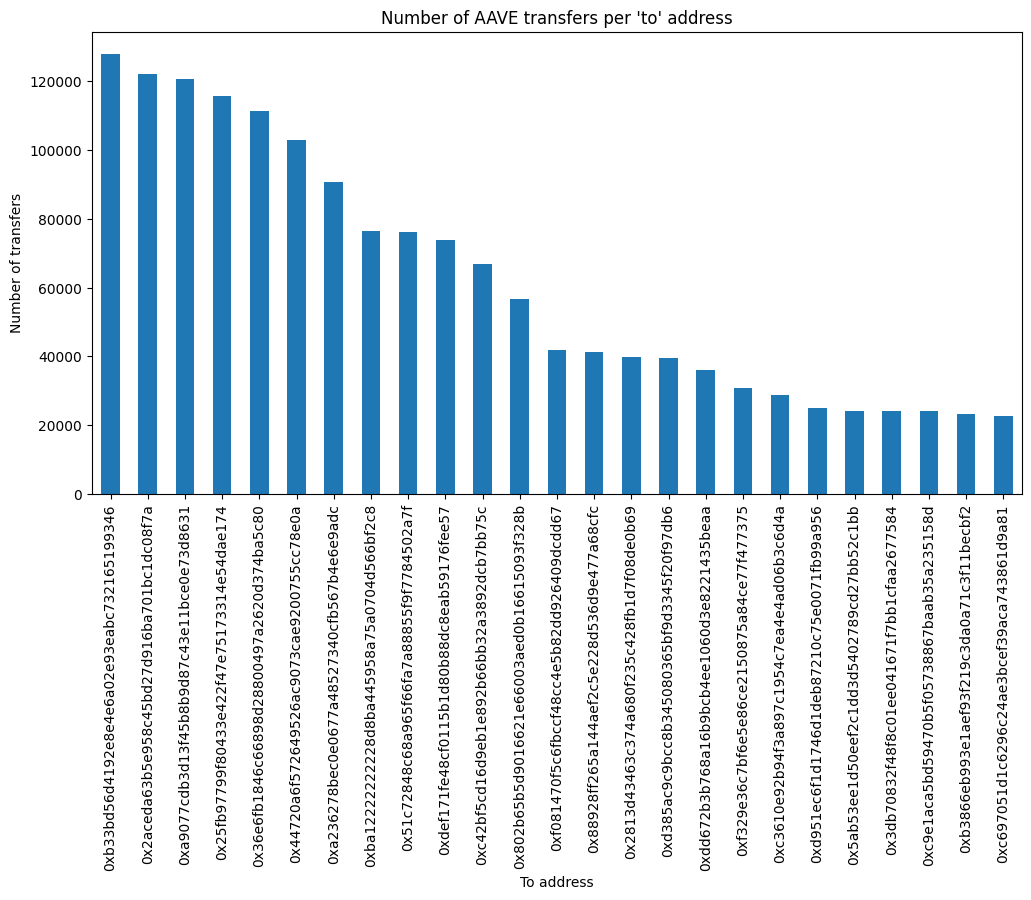

In [100]:
transfers_count_per_from = aave_df_filtered['from'].value_counts().nlargest(25)
transfers_count_per_to = aave_df_filtered['to'].value_counts().nlargest(25)

plt.figure(figsize=(12, 6))
transfers_count_per_from.plot(kind='bar')
plt.xlabel('From address')
plt.ylabel('Number of transfers')
plt.title('Number of AAVE transfers per \'from\' address')
plt.show()

plt.figure(figsize=(12, 6))
transfers_count_per_to.plot(kind='bar')
plt.xlabel('To address')
plt.ylabel('Number of transfers')
plt.title('Number of AAVE transfers per \'to\' address')
plt.show()

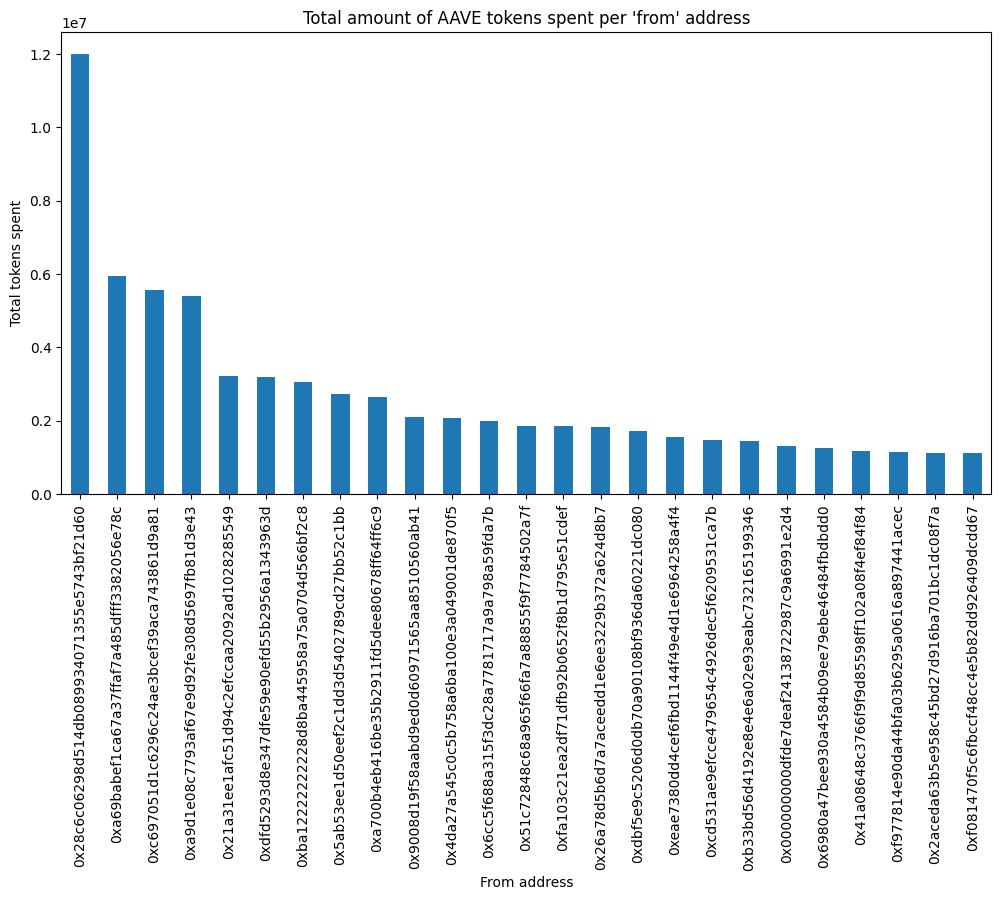

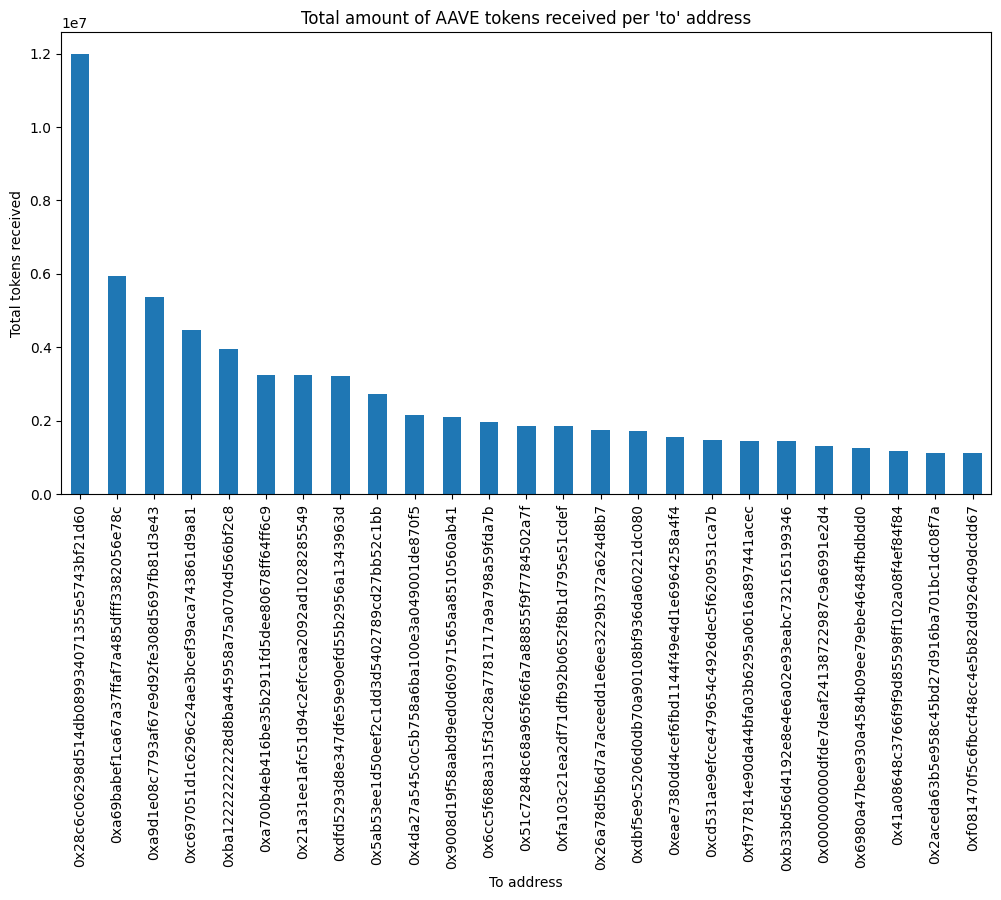

In [67]:
total_spent_per_from = aave_df_filtered.groupby('from')['value'].sum().nlargest(25)
total_received_per_to = aave_df_filtered.groupby('to')['value'].sum().nlargest(25)

plt.figure(figsize=(12, 6))
total_spent_per_from.plot(kind='bar')
plt.xlabel('From address')
plt.ylabel('Total tokens spent')
plt.title('Total amount of AAVE tokens spent per \'from\' address')
plt.show()

plt.figure(figsize=(12, 6))
total_received_per_to.plot(kind='bar')
plt.xlabel('To address')
plt.ylabel('Total tokens received')
plt.title('Total amount of AAVE tokens received per \'to\' address')
plt.show()

### aTokens

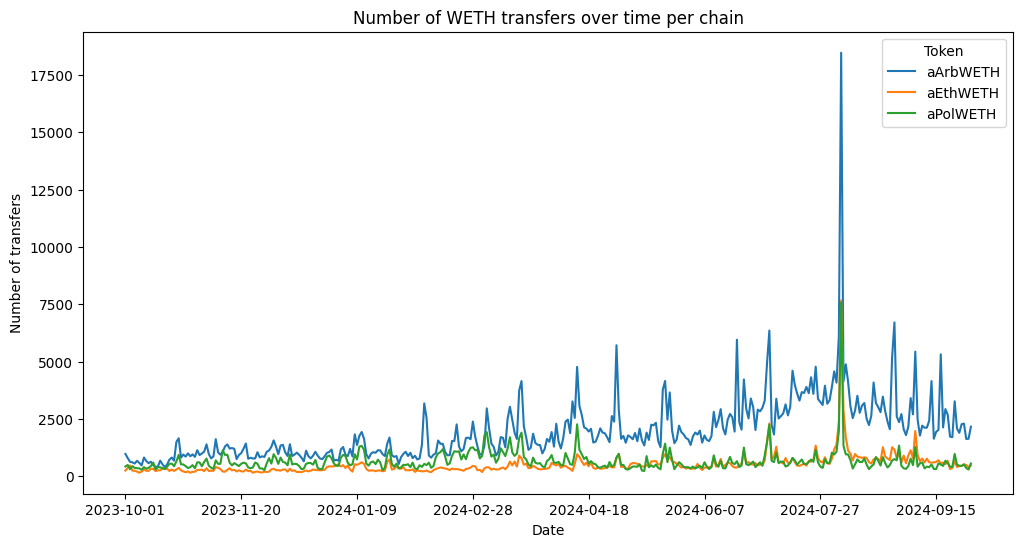

In [54]:
transfers_over_time_per_token = aToken_df.groupby(['date', 'token']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Number of transfers')
plt.title('Number of WETH transfers over time per chain')
plt.legend(title='Token')
plt.show()

C:\Users\Sam\AppData\Local\Temp\ipykernel_3892\2835992797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_3892\2835992797.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aToken_df['date'] = aToken_df['date'].dt.date


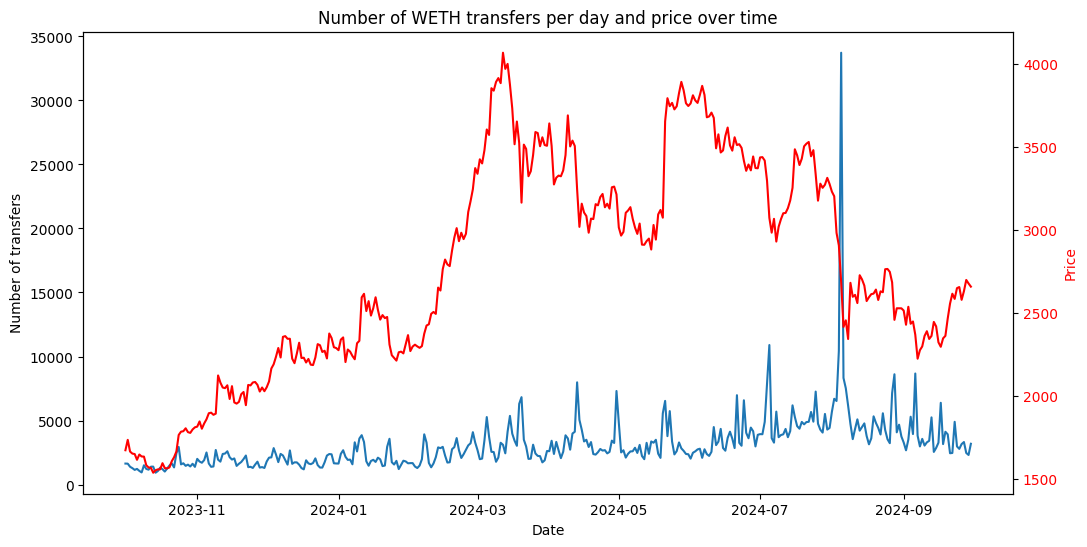

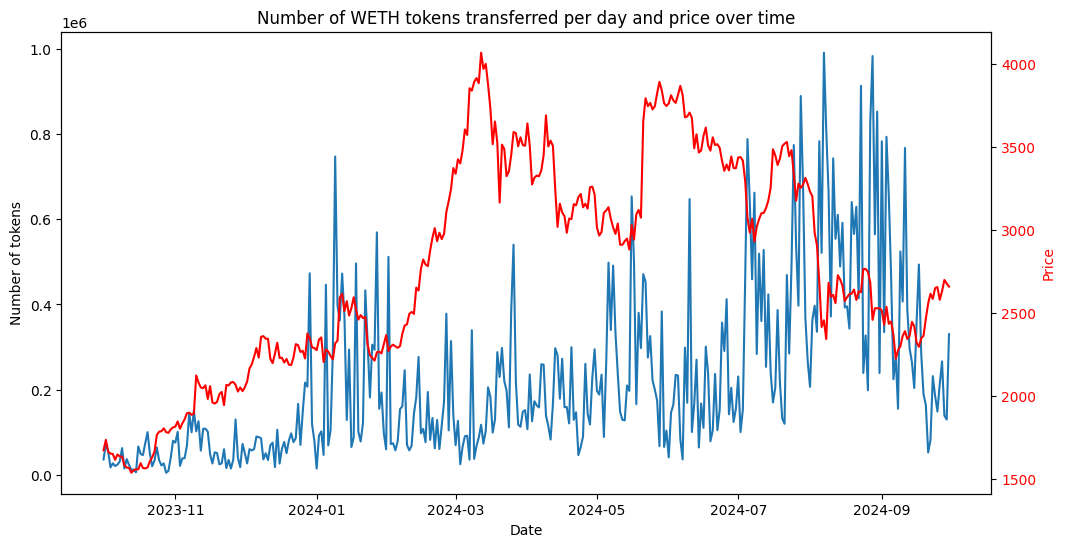

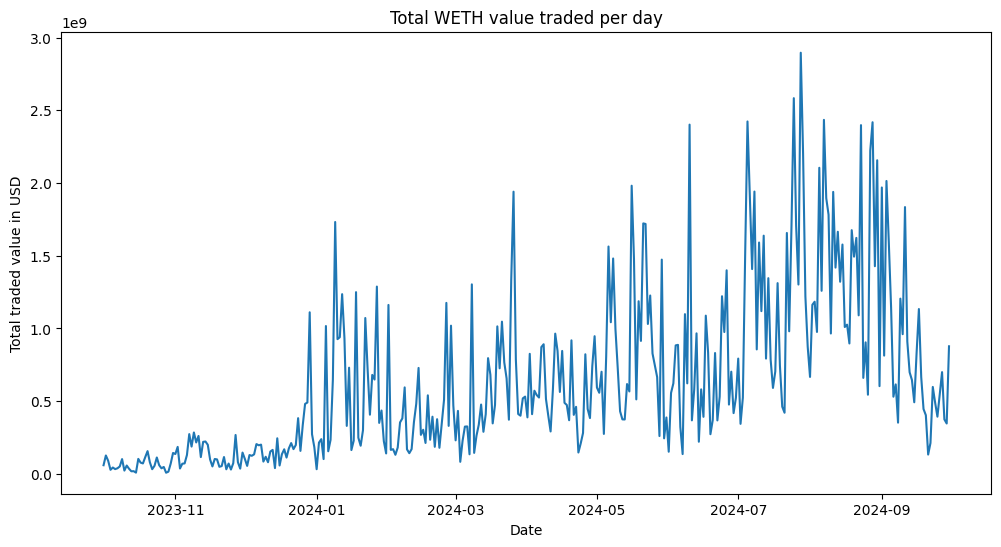

In [64]:
price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = price_data['snapped_at'].dt.date

aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
aToken_df['date'] = aToken_df['date'].dt.date

merged_data_WETH = aToken_df.groupby('date').size().reset_index(name='num_entries')
merged_data_WETH = aToken_df.groupby('date').agg(num_entries=('value', 'count'), total_value=('value', 'sum')).reset_index()
merged_data_WETH = merged_data_WETH.merge(price_data[['date', 'price']], on='date', how='left')
merged_data_WETH['total_traded_value'] = merged_data_WETH['total_value'] * merged_data_WETH['price']

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['num_entries'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of transfers')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
ax2.set_ylabel('Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH transfers per day and price over time')
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data_WETH['date'], merged_data_WETH['total_value'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tokens')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(merged_data_WETH['date'], merged_data_WETH['price'], color='red')
ax2.set_ylabel('Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Number of WETH tokens transferred per day and price over time')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_WETH['date'], merged_data_WETH['total_traded_value'])
plt.xlabel('Date')
plt.ylabel('Total traded value in USD')
plt.title('Total WETH value traded per day')
plt.show()

In [65]:
aToken_df_filtered = aToken_df[aToken_df['from'].str.lower() != aToken_df['to'].str.lower()]

aToken_self_transfers = len(aToken_df) - len(aToken_df_filtered)

print(f'Number of self-transfers in aToken_df: {aToken_self_transfers}')

Number of self-transfers in aToken_df: 76


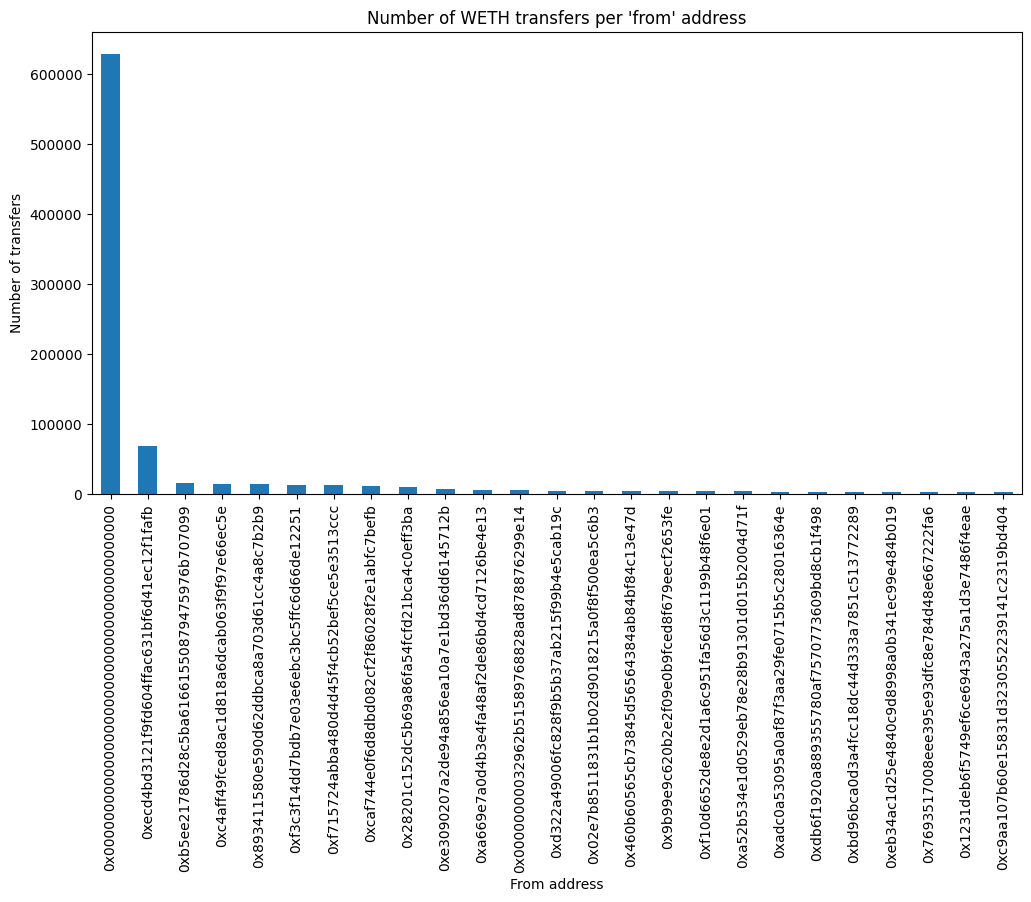

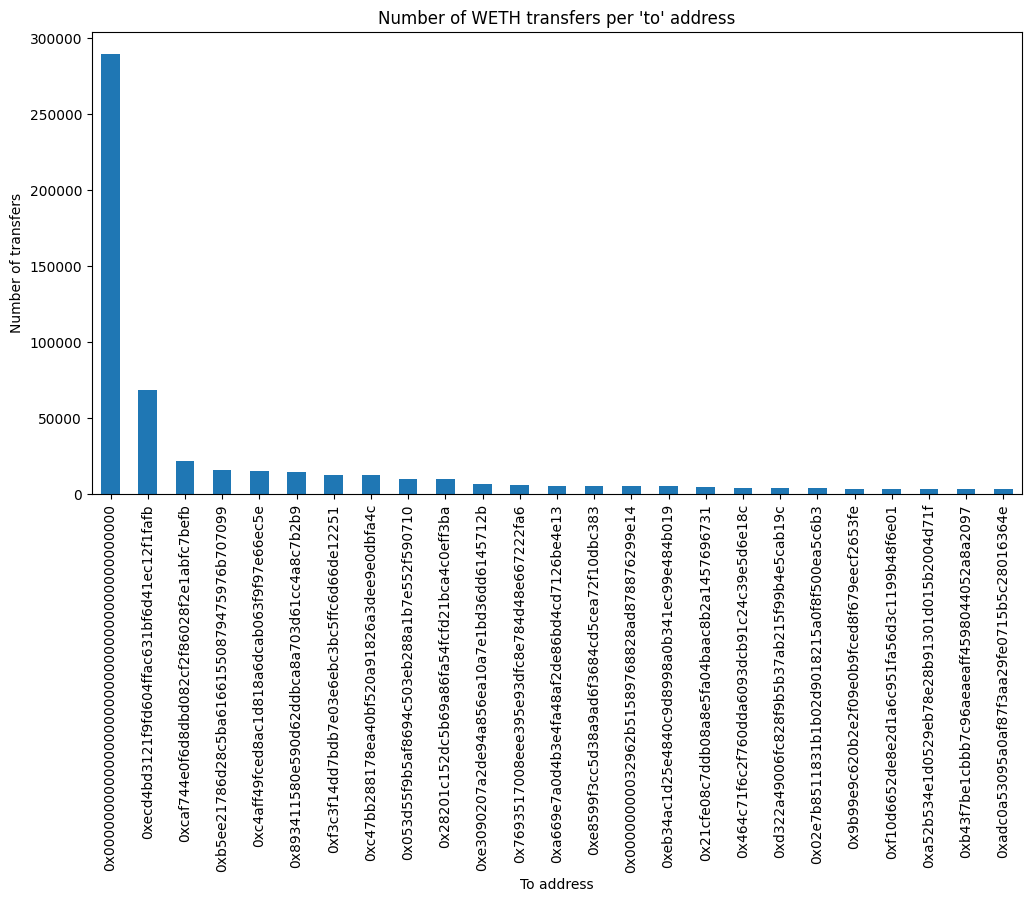

In [66]:
transfers_count_per_from = aToken_df['from'].value_counts().nlargest(25)
transfers_count_per_to = aToken_df['to'].value_counts().nlargest(25)

plt.figure(figsize=(12, 6))
transfers_count_per_from.plot(kind='bar')
plt.xlabel('From address')
plt.ylabel('Number of transfers')
plt.title('Number of WETH transfers per \'from\' address')
plt.show()

plt.figure(figsize=(12, 6))
transfers_count_per_to.plot(kind='bar')
plt.xlabel('To address')
plt.ylabel('Number of transfers')
plt.title('Number of WETH transfers per \'to\' address')
plt.show()

### Governance

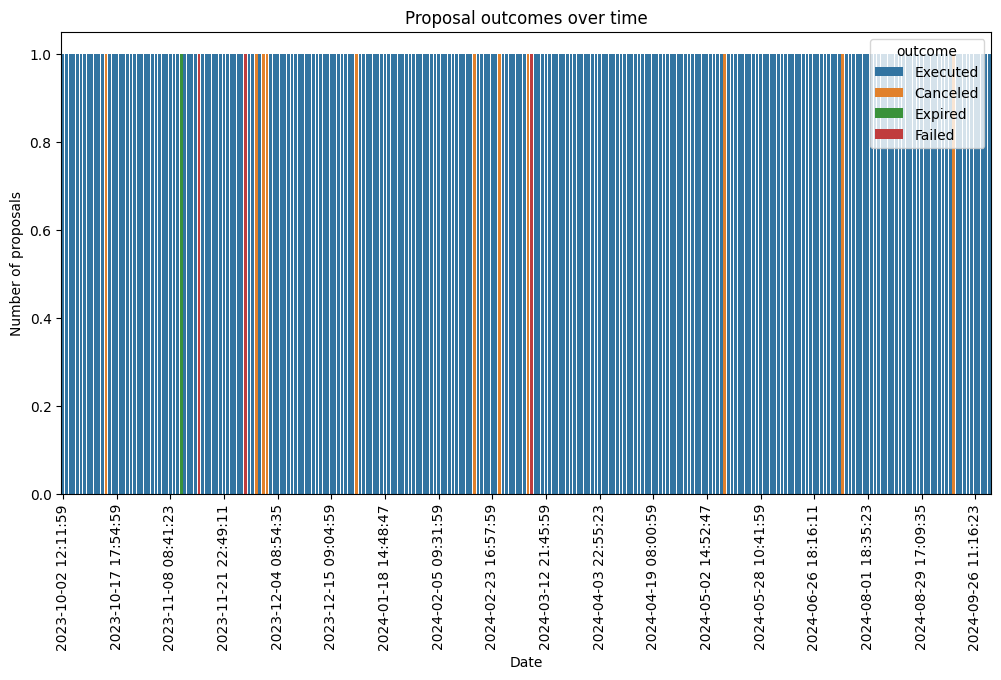

<Figure size 1200x600 with 0 Axes>

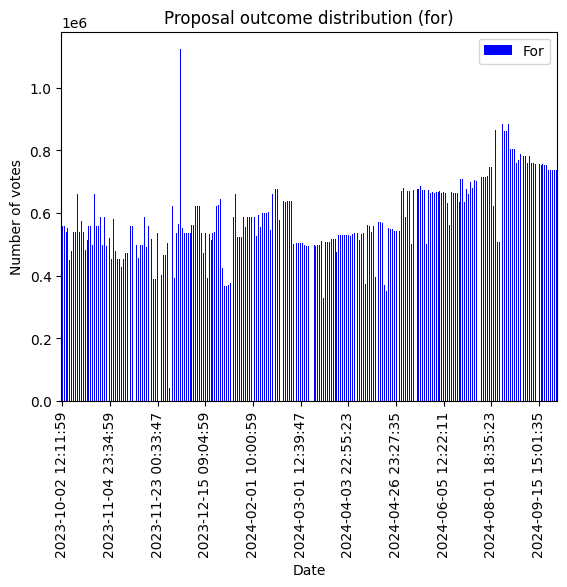

<Figure size 1200x600 with 0 Axes>

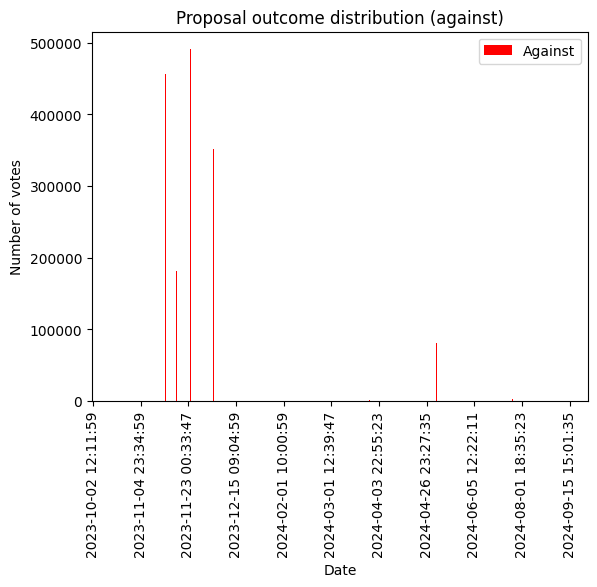

In [ ]:
proposal_dates = [datetime.fromtimestamp(proposal['timestamp']) for proposal in aave_v2_proposals] + \
                 [datetime.fromtimestamp(int(proposal['transactions']['created']['timestamp'])) for proposal in aave_v3_proposals]

proposal_outcomes_df = pd.DataFrame({
    'date': proposal_dates,
    'outcome': [proposal['state'] for proposal in aave_v2_proposals] + [proposal['state'] for proposal in aave_v3_proposals]
})

proposal_outcomes_df = proposal_outcomes_df.sort_values(by='date')
# proposal_outcomes_df['date'] = proposal_outcomes_df['date'].dt.date

proposal_outcome_distribution = pd.DataFrame({
    'date': proposal_dates,
    'For': [float(proposal['currentYesVote']) for proposal in aave_v2_proposals] +
           [float(proposal['votes']['forVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals],
    'Against': [float(proposal['currentNoVote']) for proposal in aave_v2_proposals] +
               [float(proposal['votes']['againstVotes']) if proposal['votes'] else 0 for proposal in aave_v3_proposals]
})

proposal_outcome_distribution = proposal_outcome_distribution.sort_values(by='date')
# proposal_outcome_distribution['date'] = proposal_outcome_distribution['date'].dt.date

plt.figure(figsize=(12, 6))
sns.countplot(data=proposal_outcomes_df, x='date', hue='outcome')
plt.xlabel('Date')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes over time')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))
plt.show()

# plt.figure(figsize=(12, 6))
# proposal_outcome_distribution.plot(kind='bar', stacked=True)
# plt.xlabel('Proposal')
# plt.ylabel('Number of votes')
# plt.title('Proposal outcome distribution')
# plt.show()

plt.figure(figsize=(12, 6))
proposal_outcome_distribution.plot(x='date', y='For', kind='bar', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of votes')
plt.title('Proposal outcome distribution (for)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

plt.figure(figsize=(12, 6))
proposal_outcome_distribution.plot(x='date', y='Against', kind='bar', color='red')
plt.xlabel('Date')
plt.ylabel('Number of votes')
plt.title('Proposal outcome distribution (against)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

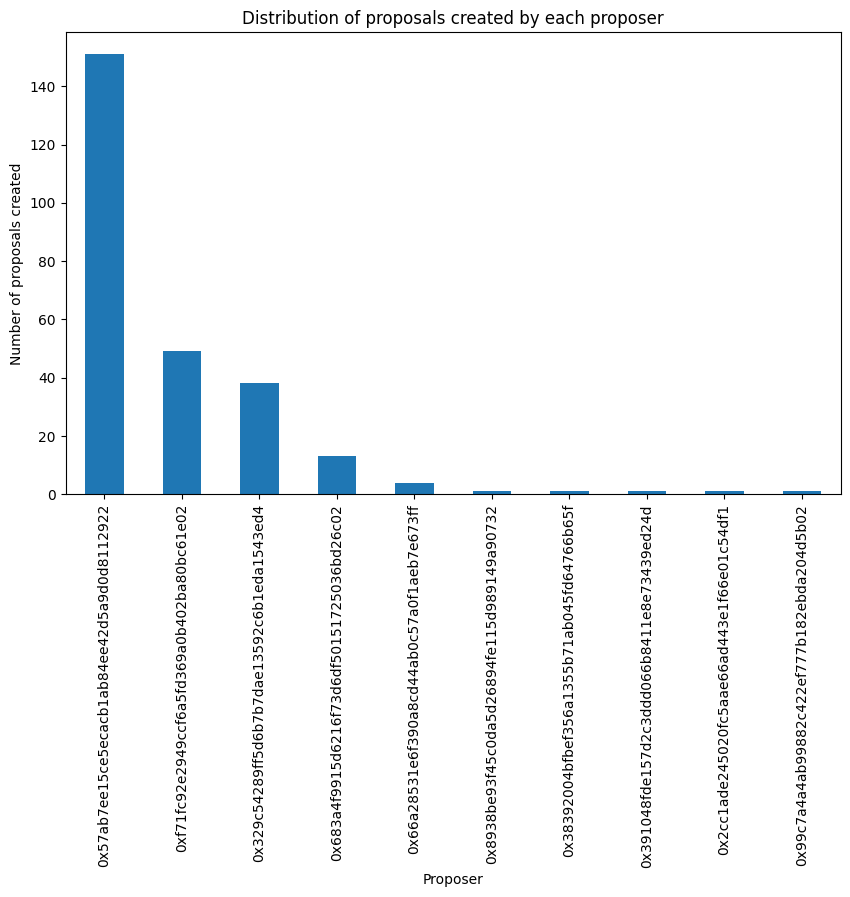

In [28]:
proposer_counts = pd.Series([proposal['user']['id'] for proposal in aave_v2_proposals] + 
                            [proposal['creator'] for proposal in aave_v3_proposals]).value_counts()

plt.figure(figsize=(10, 6))
proposer_counts.plot(kind='bar')
plt.xlabel('Proposer')
plt.ylabel('Number of proposals created')
plt.title('Distribution of proposals created by each proposer')
plt.show()

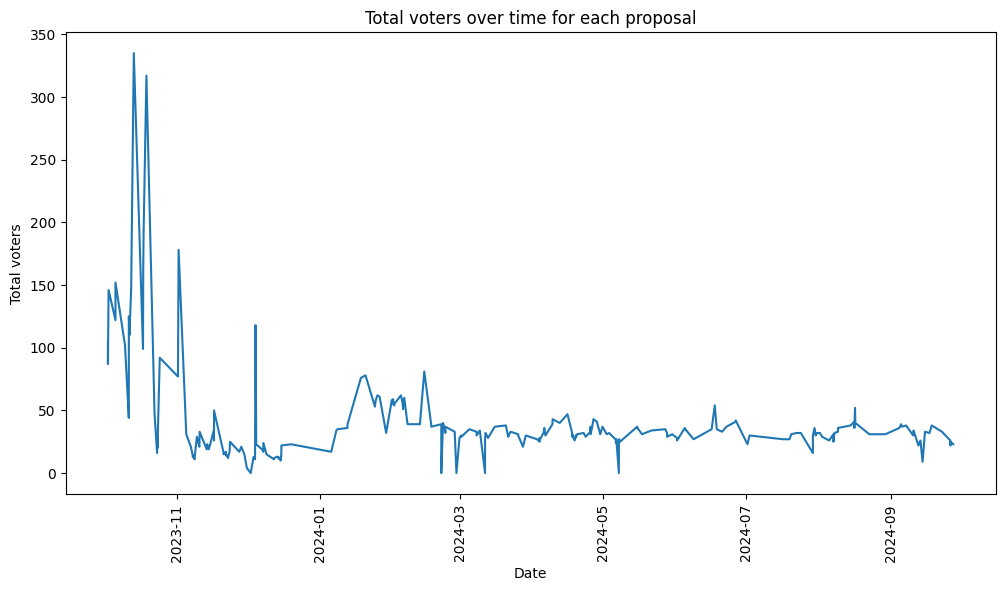

In [29]:
proposal_voters_df = pd.DataFrame({
    'date': proposal_dates,
    'totalCurrentVoters': [proposal['totalCurrentVoters'] for proposal in aave_v2_proposals] + 
                        [proposal['totalCurrentVoters'] for proposal in aave_v3_proposals]
})

proposal_voters_df = proposal_voters_df.sort_values(by='date')

plt.figure(figsize=(12, 6))
plt.plot(proposal_voters_df['date'], proposal_voters_df['totalCurrentVoters'])
plt.xlabel('Date')
plt.ylabel('Total voters')
plt.title('Total voters over time for each proposal')
plt.xticks(rotation=90)
plt.show()

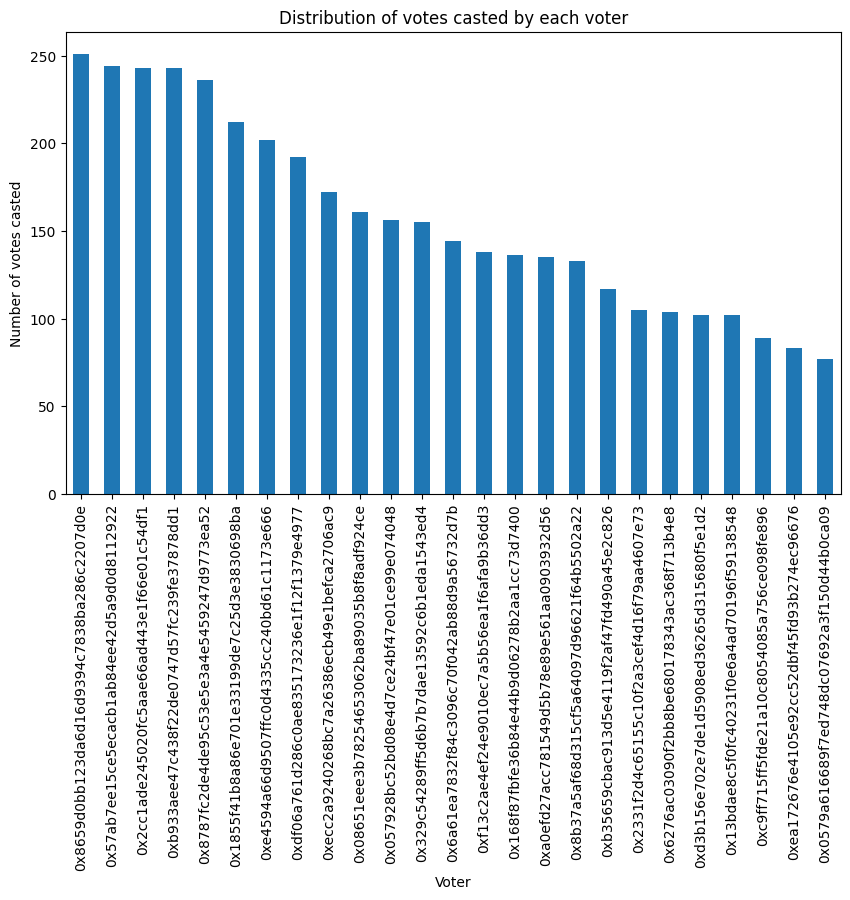

In [30]:
voter_counts = pd.Series([vote['id'].split('-')[0] for votes in aave_v2_votes for vote in votes['votes']] + 
                         [vote['voter'].lower() for votes in aave_v3_votes for vote in votes['votes']]).value_counts()[:25]

plt.figure(figsize=(10, 6))
voter_counts.plot(kind='bar')
plt.xlabel('Voter')
plt.ylabel('Number of votes casted')
plt.title('Distribution of votes casted by each voter')
plt.show()

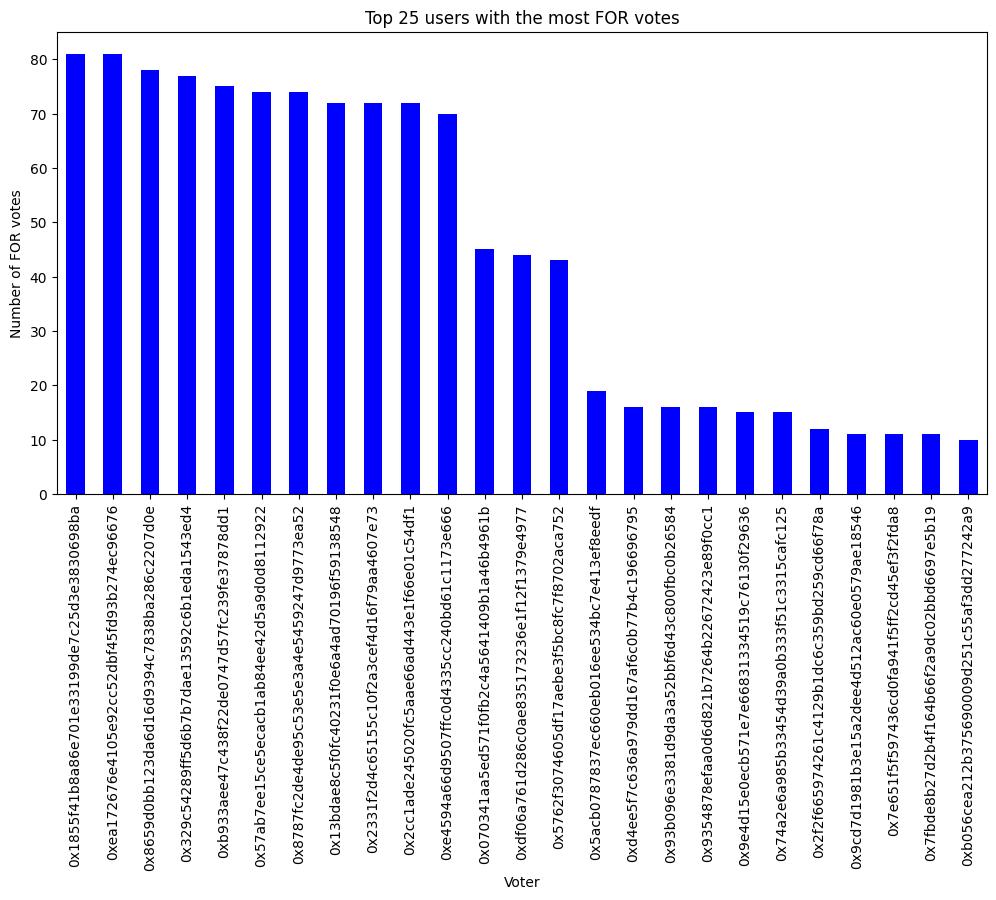

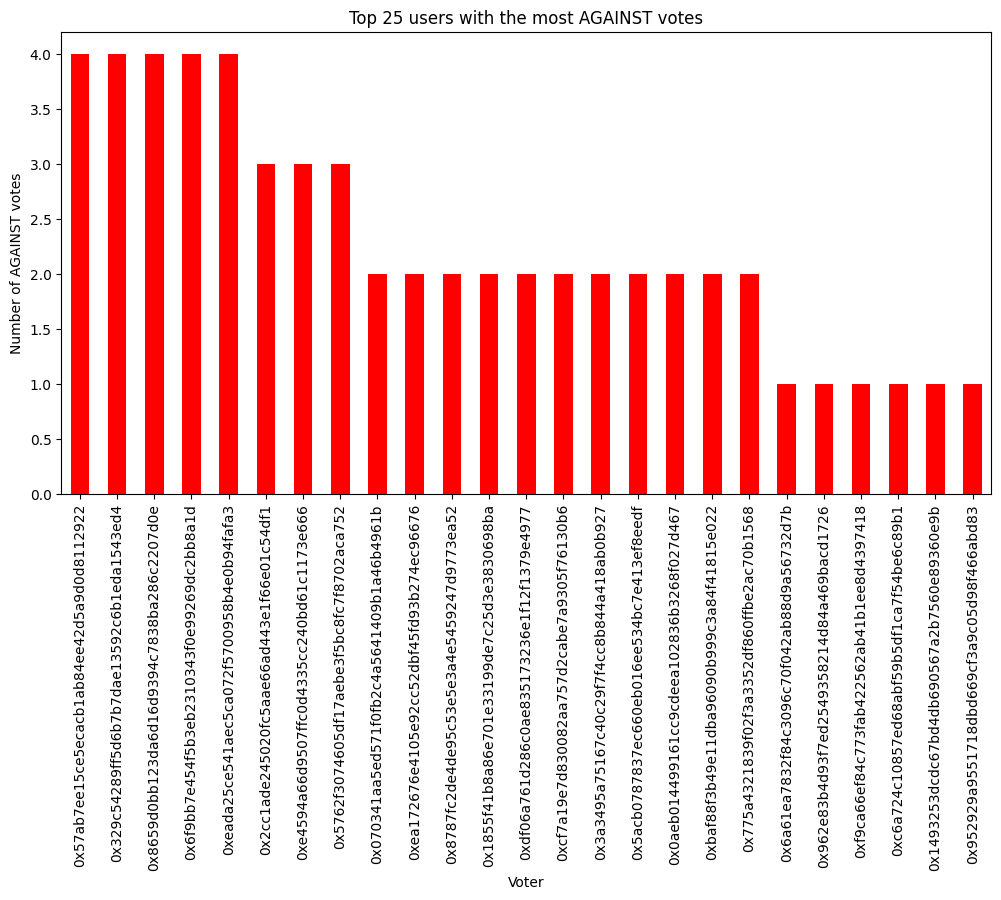

In [31]:
for_votes = {}
against_votes = {}

for votes in aave_v2_votes:
    for vote in votes['votes']:
        voter = vote['id'].split('-')[0]
        if vote['choice'] == 'FOR':
            if voter in for_votes:
                for_votes[voter] += 1
            else:
                for_votes[voter] = 1
        elif vote['choice'] == 'AGAINST':
            if voter in against_votes:
                against_votes[voter] += 1
            else:
                against_votes[voter] = 1

for votes in aave_v3_votes:
    for vote in votes['votes']:
        voter = vote['voter'].lower()
        if vote['choice'] == 1:
            if voter in for_votes:
                for_votes[voter] += 1
            else:
                for_votes[voter] = 1
        elif vote['choice'] == 0:
            if voter in against_votes:
                against_votes[voter] += 1
            else:
                against_votes[voter] = 1

for_votes_series = pd.Series(for_votes).nlargest(25)
against_votes_series = pd.Series(against_votes).nlargest(25)

plt.figure(figsize=(12, 6))
for_votes_series.plot(kind='bar', color='blue')
plt.xlabel('Voter')
plt.ylabel('Number of FOR votes')
plt.title('Top 25 users with the most FOR votes')
plt.show()

plt.figure(figsize=(12, 6))
against_votes_series.plot(kind='bar', color='red')
plt.xlabel('Voter')
plt.ylabel('Number of AGAINST votes')
plt.title('Top 25 users with the most AGAINST votes')
plt.show()

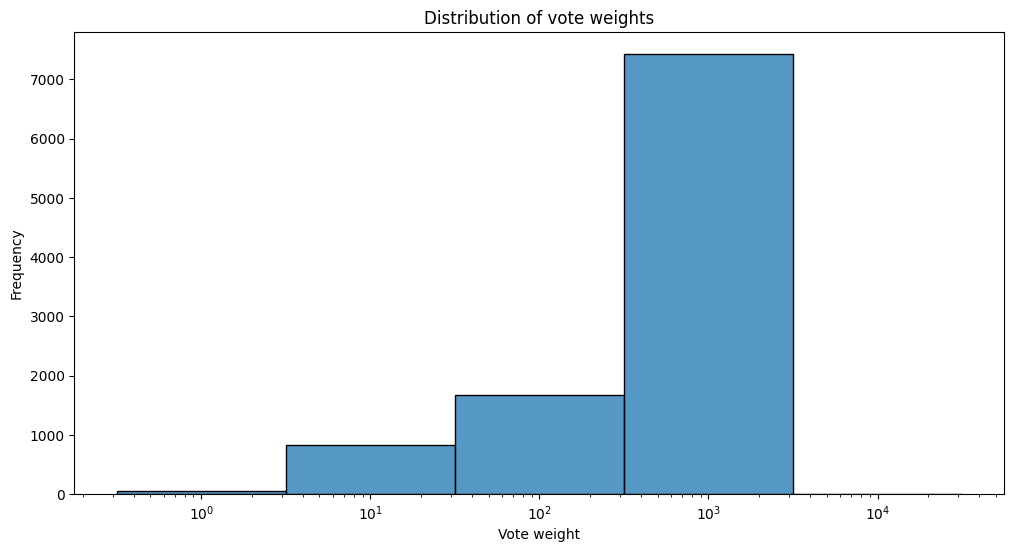

In [38]:
vote_weights = []

for votes in aave_v2_votes:
    for vote in votes['votes']:
        vote_weights.append(vote['weight'])

for votes in aave_v3_votes:
    for vote in votes['votes']:
        vote_weights.append(vote['weight'])

plt.figure(figsize=(12, 6))
sns.histplot(vote_weights, bins=50, log_scale=(True, False))
plt.xlabel('Vote weight')
plt.ylabel('Frequency')
plt.title('Distribution of vote weights')
plt.show()

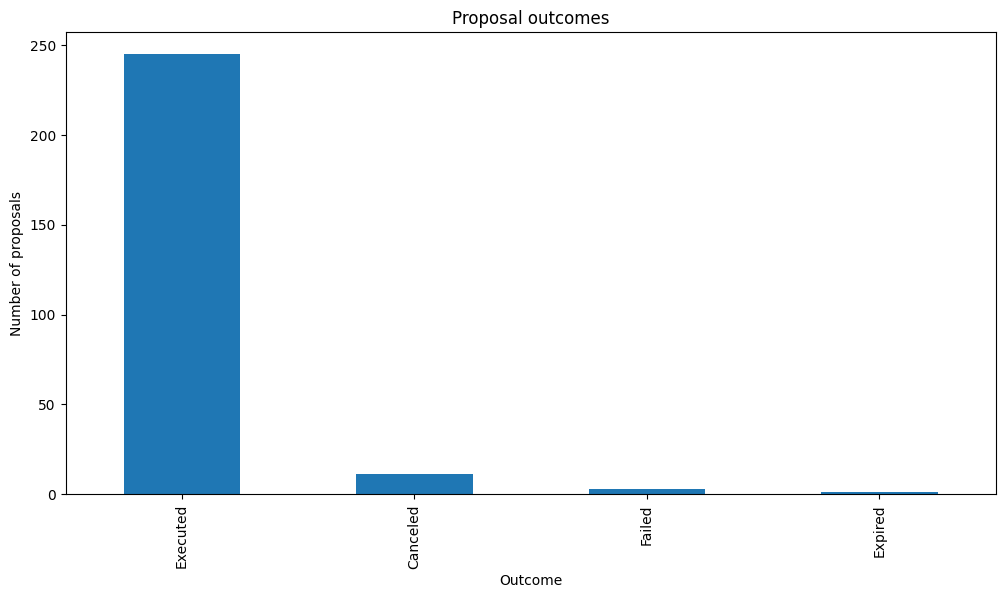

In [33]:
proposal_outcomes = pd.Series([proposal['state'] for proposal in aave_v2_proposals + aave_v3_proposals])

plt.figure(figsize=(12, 6))
proposal_outcomes.value_counts().plot(kind='bar')
plt.xlabel('Outcome')
plt.ylabel('Number of proposals')
plt.title('Proposal outcomes')
plt.show()

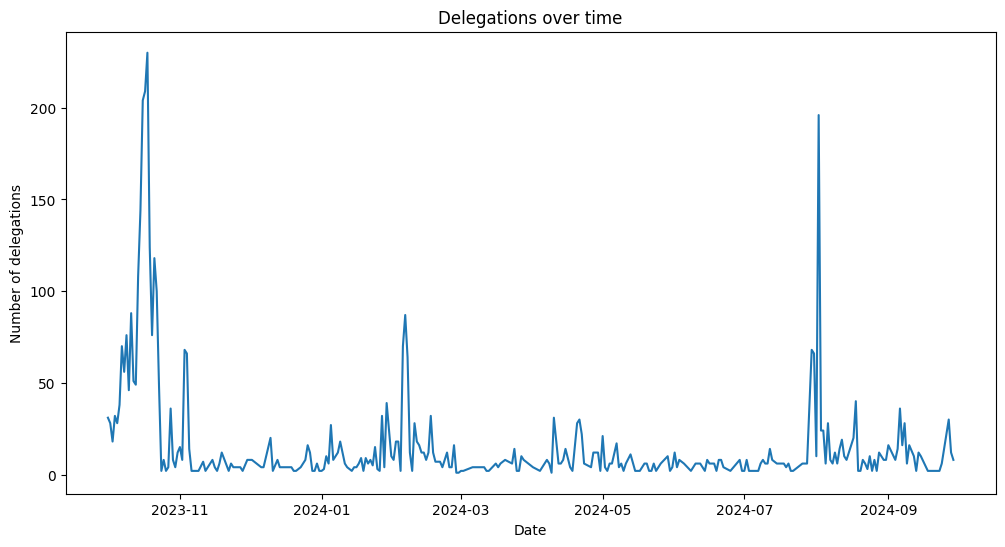

In [34]:
delegations_df = pd.DataFrame(delegations)
delegations_df['date'] = pd.to_datetime(delegations_df['timestamp'], unit='s')
delegations_df['date'] = delegations_df['date'].dt.date
delegations_over_time = delegations_df.groupby('date').size()

plt.figure(figsize=(12, 6))
delegations_over_time.plot()
plt.xlabel('Date')
plt.ylabel('Number of delegations')
plt.title('Delegations over time')
plt.show()

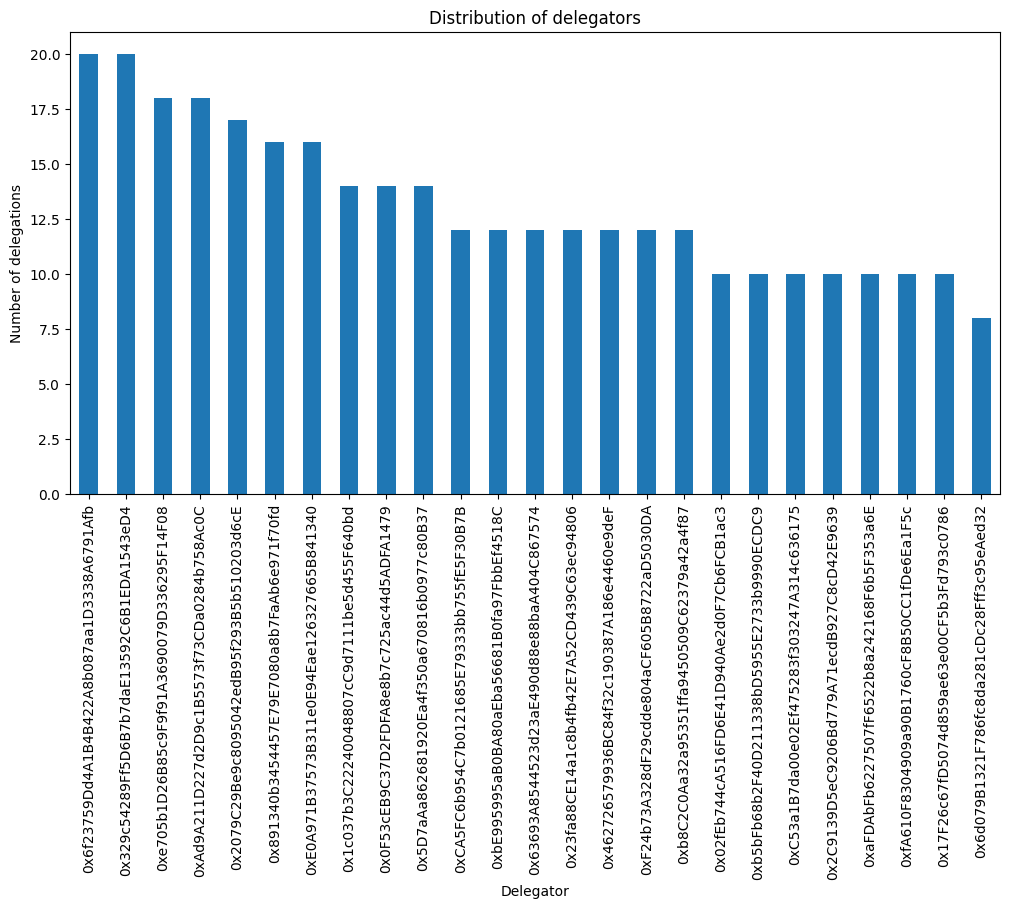

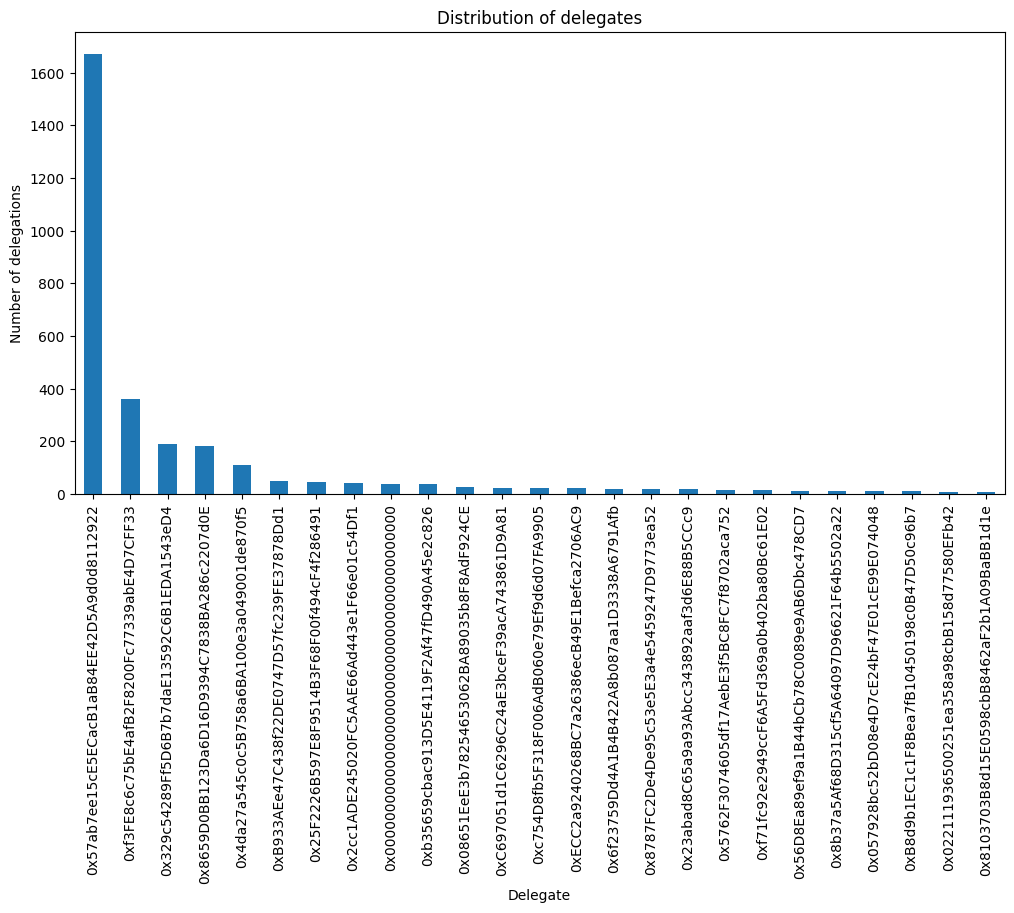

In [35]:
delegator_counts = delegations_df['from'].value_counts()[:25]
delegate_counts = delegations_df['to'].value_counts()[:25]

plt.figure(figsize=(12, 6))
delegator_counts.plot(kind='bar')
plt.xlabel('Delegator')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegators')
plt.show()

plt.figure(figsize=(12, 6))
delegate_counts.plot(kind='bar')
plt.xlabel('Delegate')
plt.ylabel('Number of delegations')
plt.title('Distribution of delegates')
plt.show()

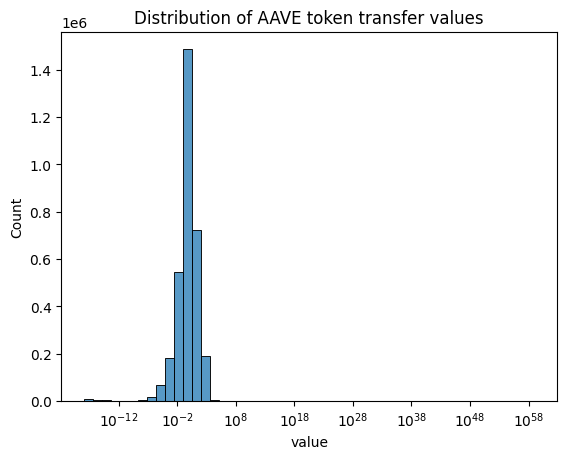

In [28]:
sns.histplot(aave_df['value'], bins=50, log_scale=(True, False))
plt.title('Distribution of AAVE token transfer values')
plt.show()

## aToken network analysis

In [92]:
combined_tokens = {
    'USDC': ['aEthUSDC', 'aPolUSDC', 'aArbUSDC'],
    'USDT': ['aEthUSDT', 'aPolUSDT', 'aArbUSDT'],
    'WETH': ['aEthWETH', 'aPolWETH', 'aArbWETH']
}

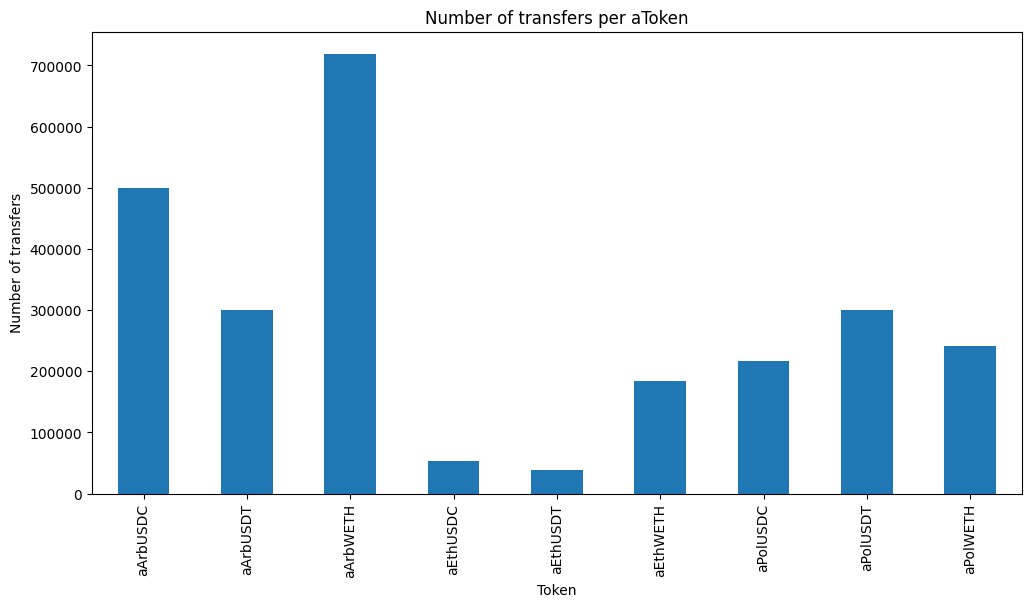

In [117]:
transfers_per_token = aToken_df.groupby('token').size()

# transfers_per_token = pd.Series({token: transfers_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Number of transfers')
plt.title('Number of transfers per aToken')
plt.show()

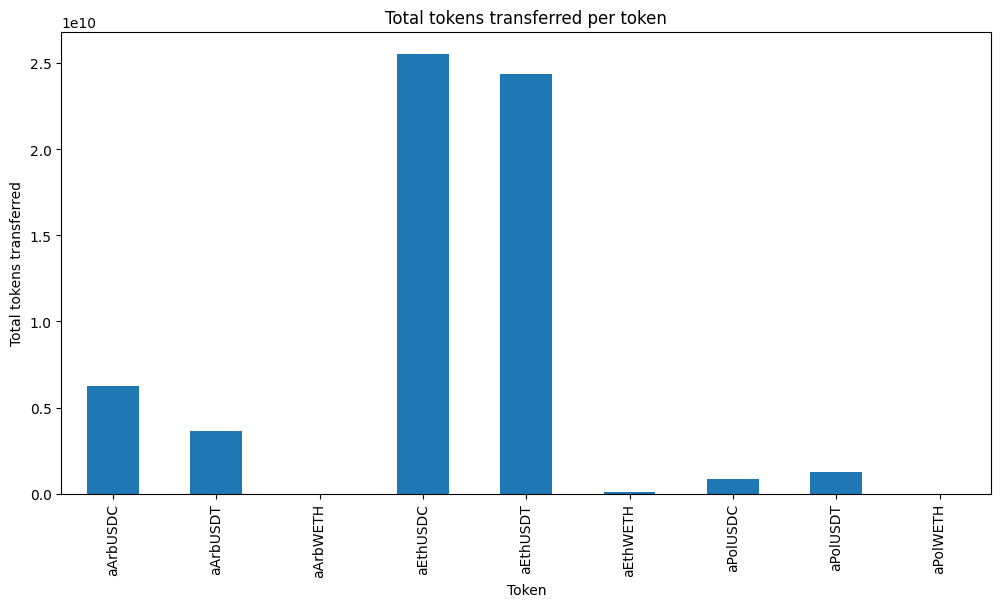

In [119]:
summed_weights_per_token = aToken_df.groupby('token')['value'].sum()

# summed_weights_per_token = pd.Series({token: summed_weights_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
summed_weights_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total tokens transferred')
plt.title('Total tokens transferred per token')
plt.show()

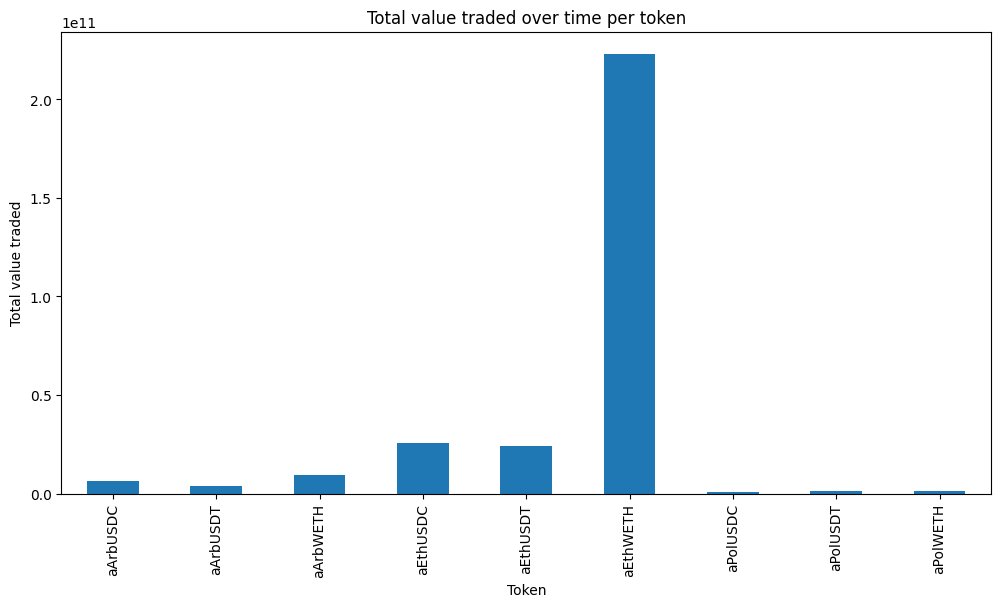

In [129]:
# price_data = pd.read_csv('data/weth-usd-max.csv', parse_dates=['snapped_at'])

# price_data['date'] = pd.to_datetime(price_data['snapped_at']).dt.date
# aToken_df['date'] = pd.to_datetime(aToken_df['timestamp'], unit='s')
# aToken_df['date'] = aToken_df['date'].dt.date

# aToken_df2 = aToken_df.merge(price_data[['date', 'price']], on='date', how='left')

tokens_to_multiply = ['aArbWETH', 'aEthWETH', 'aPolWETH']

aToken_df2['value_traded'] = aToken_df2.apply(
    lambda row: row['value'] * row['price'] if row['token'] in tokens_to_multiply else row['value'], axis=1
)

transfers_over_time_per_token = aToken_df2.groupby('token')['value_traded'].sum()

# transfers_over_time_per_token = pd.Series({token: transfers_over_time_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total value traded')
plt.title('Total value traded over time per token')
plt.show()

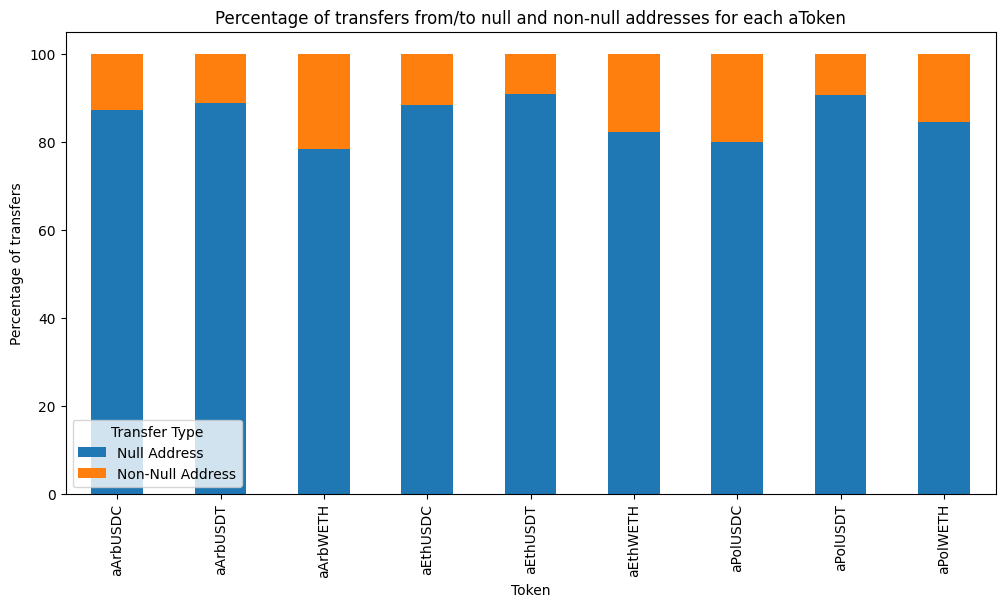

In [ ]:
null_address = '0x0000000000000000000000000000000000000000'

total_transfers_per_token = aToken_df['token'].value_counts()

null_address_transfers_per_token = aToken_df[(aToken_df['from'].str.lower() == null_address) | (aToken_df['to'].str.lower() == null_address)].groupby('token').size()

percentage_null_address_transfers = (null_address_transfers_per_token / total_transfers_per_token) * 100

percentage_non_null_address_transfers = 100 - percentage_null_address_transfers

percentage_transfers_df = pd.DataFrame({
    'Null Address': percentage_null_address_transfers,
    'Non-Null Address': percentage_non_null_address_transfers
}).fillna(0)

percentage_transfers_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Token')
plt.ylabel('Percentage of transfers')
plt.title('Percentage of transfers from/to null and non-null addresses for each aToken')
plt.legend(title='Transfer Type')
plt.show()

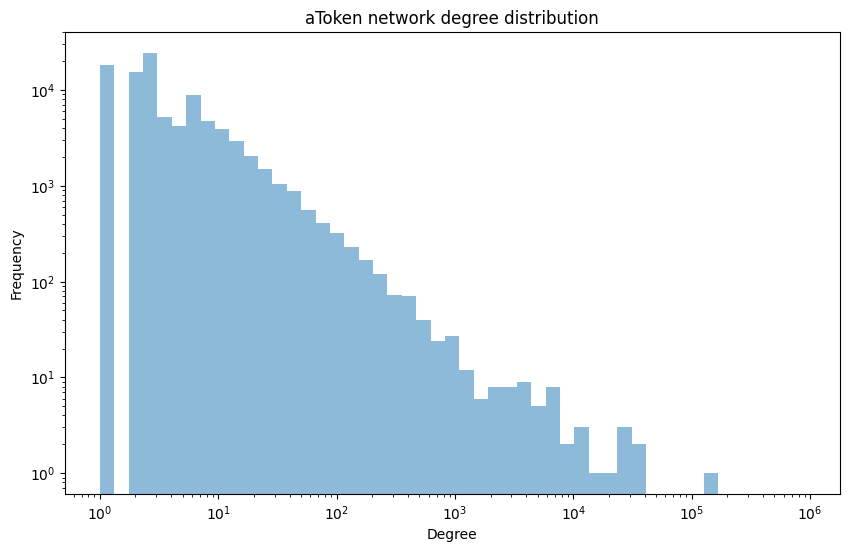

In [70]:
degrees = [degree for _, degree in G_aToken.degree()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'aToken network degree distribution')
plt.show()

In [ ]:
aToken_pr = nx.pagerank(G_aToken)
aToken_dc = nx.degree_centrality(G_aToken)

sorted_aToken_pr = sorted(aToken_pr.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_aToken_dc = sorted(aToken_dc.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Pagerank Scores:")
for node, score in sorted_aToken_pr:
    print(f"Node: {node}, Score: {score}")

print("\nTop 10 Degree Centrality Scores:")
for node, score in sorted_aToken_dc:
    print(f"Node: {node}, Score: {score}")

Top 10 Pagerank Scores:
Node: 0x0000000000000000000000000000000000000000, Score: 0.3597934806609729
Node: 0x00000000032962b51589768828ad878876299e14, Score: 0.1439656862598906
Node: 0xecd4bd3121f9fd604ffac631bf6d41ec12f1fafb, Score: 0.05011179235774628
Node: 0x893411580e590d62ddbca8a703d61cc4a8c7b2b9, Score: 0.03450585988726754
Node: 0xa6381631e0634e97e23a80a3c57f9582aa959e16, Score: 0.02465102210258189
Node: 0x8ce3c66b4663090980f6ca05ae3bc390d74731e9, Score: 0.01635719360463878
Node: 0xb5ee21786d28c5ba61661550879475976b707099, Score: 0.013951460814310082
Node: 0xd322a49006fc828f9b5b37ab215f99b4e5cab19c, Score: 0.012840212957284996
Node: 0x9c27145a914007b20f9e84bd9a79782fee7e91df, Score: 0.011649819805571938
Node: 0x1aecea38b8626eeb3748234343cff427268dd487, Score: 0.00426788323168976

Top 10 Degree Centrality Scores:
Node: 0x0000000000000000000000000000000000000000, Score: 9.344334008477585
Node: 0xecd4bd3121f9fd604ffac631bf6d41ec12f1fafb, Score: 1.4221565638637739
Node: 0xcaf744e0f6d8

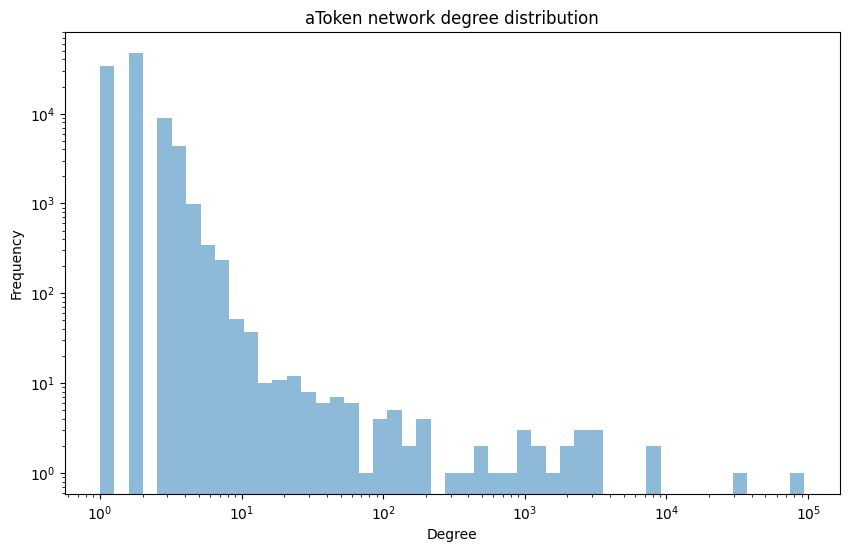

In [72]:
degrees = [degree for _, degree in G_aToken_undirected.degree()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'aToken network degree distribution')
plt.show()

In [73]:
aToken_undirected_pr = nx.pagerank(G_aToken_undirected)
aToken_undirected_dc = nx.degree_centrality(G_aToken_undirected)

sorted_aToken_undirected_pr = sorted(aToken_undirected_pr.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_aToken_undirected_dc = sorted(aToken_undirected_dc.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Pagerank Scores:")
for node, score in sorted_aToken_undirected_pr:
    print(f"Node: {node}, Score: {score}")

print("\nTop 10 Degree Centrality Scores:")
for node, score in sorted_aToken_undirected_dc:
    print(f"Node: {node}, Score: {score}")

Top 10 Pagerank Scores:
Node: 0x0000000000000000000000000000000000000000, Score: 0.41810765452589077
Node: 0x00000000032962b51589768828ad878876299e14, Score: 0.19438759647637585
Node: 0xa6381631e0634e97e23a80a3c57f9582aa959e16, Score: 0.02898806741919912
Node: 0xecd4bd3121f9fd604ffac631bf6d41ec12f1fafb, Score: 0.02496804694175263
Node: 0x8ce3c66b4663090980f6ca05ae3bc390d74731e9, Score: 0.02139804788519146
Node: 0x893411580e590d62ddbca8a703d61cc4a8c7b2b9, Score: 0.018106835385322137
Node: 0x9c27145a914007b20f9e84bd9a79782fee7e91df, Score: 0.015535079202210712
Node: 0xd322a49006fc828f9b5b37ab215f99b4e5cab19c, Score: 0.008507194778373186
Node: 0xb5ee21786d28c5ba61661550879475976b707099, Score: 0.008279324644210294
Node: 0x0eb623c1297e594a83e6309fec8a96c1efe873e6, Score: 0.003399464984415477

Top 10 Degree Centrality Scores:
Node: 0x0000000000000000000000000000000000000000, Score: 0.9830343905953102
Node: 0xecd4bd3121f9fd604ffac631bf6d41ec12f1fafb, Score: 0.3211563759370236
Node: 0xb5ee217

In [ ]:
aToken_ac = nx.degree_assortativity_coefficient(G_aToken, weight='weight')

## Governance network analysis

In [125]:
G_governance = nx.MultiDiGraph()

G_governance.add_nodes_from(proposers, layer='proposer')
G_governance.add_nodes_from(voters, layer='voter')
G_governance.add_nodes_from(delegators, layer='delegation')
G_governance.add_nodes_from(delegates, layer='delegation')
G_governance.add_nodes_from([proposal['id'] for proposal in aave_v2_proposals], layer='proposal')
G_governance.add_nodes_from([proposal['id'] for proposal in aave_v3_proposals], layer='proposal')
# G_governance.add_nodes_from([proposal['id'] for proposal in aave_snapshot_proposals], layer='proposal')

for delegate in delegations:
    G_governance.add_edge(delegate['from'].lower(), delegate['to'].lower(), type='delegate')

for votes in aave_v2_votes:
    for vote in votes['votes']:
        G_governance.add_edge(vote['id'].split('-')[0], votes['proposal_id'], weight=vote['weight'], type='vote', choice=vote['choice'])

for votes in aave_v3_votes:
    for vote in votes['votes']:
        G_governance.add_edge(vote['voter'].lower(), votes['proposal_id'], weight=vote['weight'], type='vote', choice='FOR' if vote['choice'] == 1 else 'AGAINST')

# for votes in aave_snapshot_votes:
#     for vote in votes['votes']:
#         G_governance.add_edge(vote['voter'].lower(), votes['proposal_id'], weight=vote['vp'], type='vote')

for proposal in aave_v2_proposals:
    G_governance.add_edge(proposal['user']['id'], proposal['id'], type='propose')

for proposal in aave_v3_proposals:
    G_governance.add_edge(proposal['creator'], proposal['id'], type='propose')

# for proposal in aave_snapshot_proposals:
#     G_governance.add_edge(proposal['author'].lower(), proposal['id'], type='propose')

In [126]:
print(len(G_governance.nodes()), len(G_governance.edges()))

4471 14999


## Venn diagrams

<Axes: >

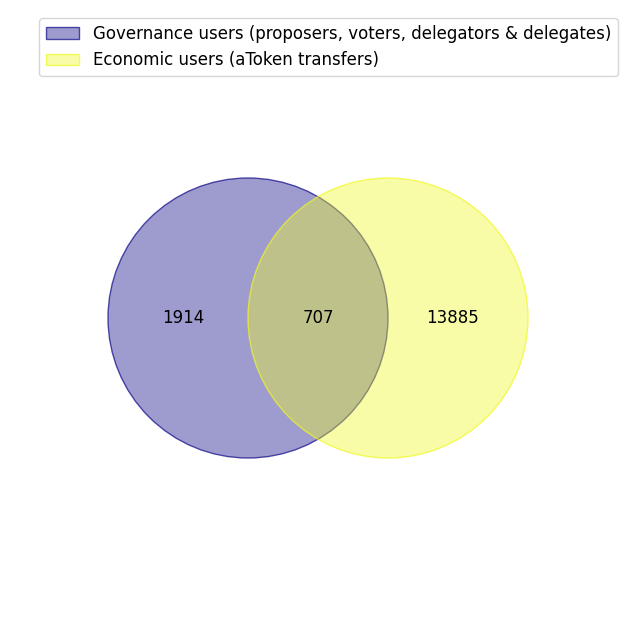

In [72]:
subsets = {
    'Governance users (proposers, voters, delegators & delegates)': governance_users,
    'Economic users (aToken transfers)': economic_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

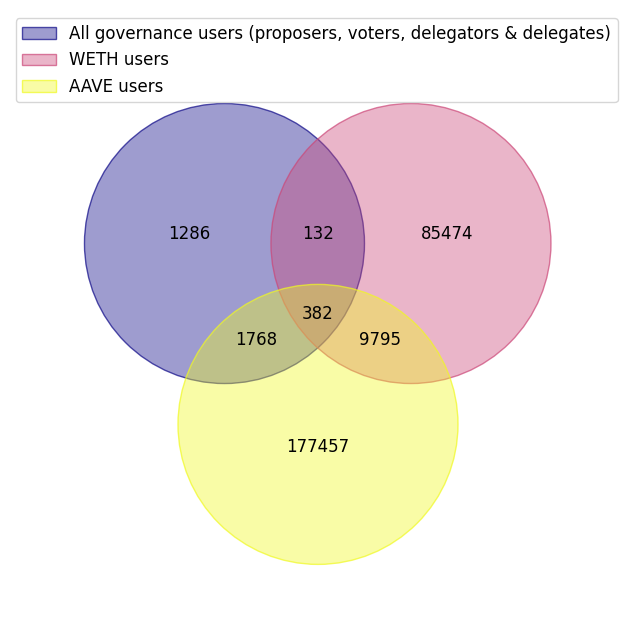

In [20]:
subsets = {
    'All governance users (proposers, voters, delegators & delegates)': all_governance_users,
    'WETH users': WETH_users,
    'AAVE users': AAVE_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

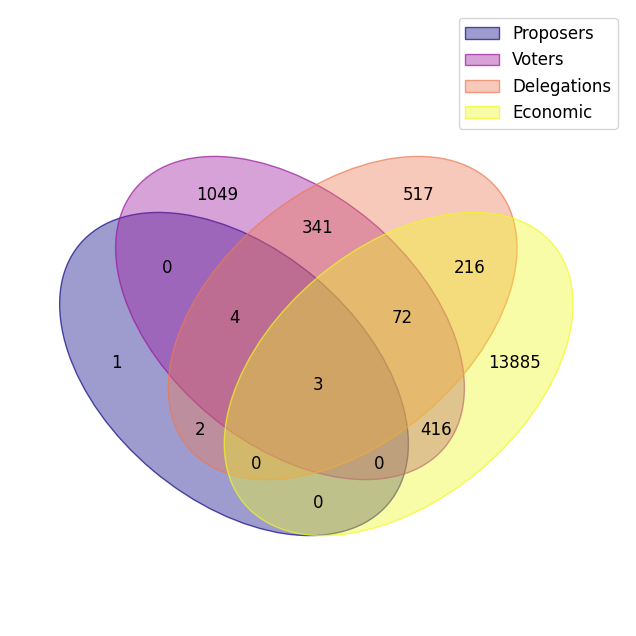

In [74]:
subsets = {
    'Proposers': proposers,
    'Voters': voters,
    'Delegations': all_delegations,
    'Economic': economic_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

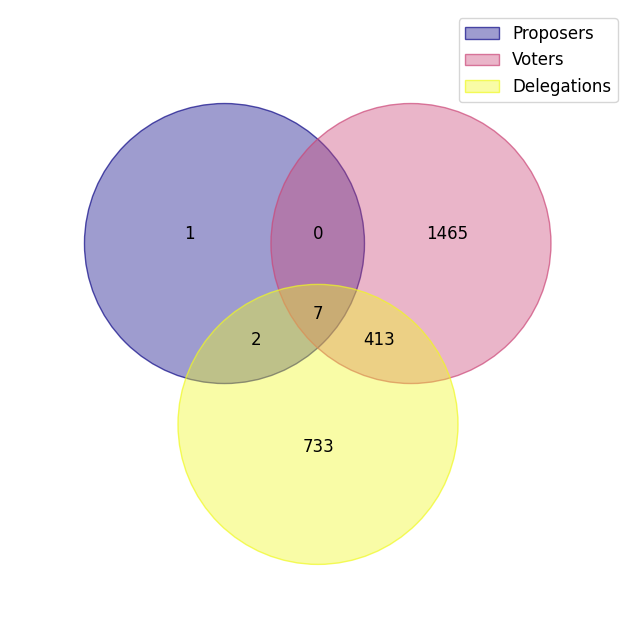

In [19]:
subsets = {
    "Proposers": proposers,
    "Voters": voters,
    "Delegations": all_delegations
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

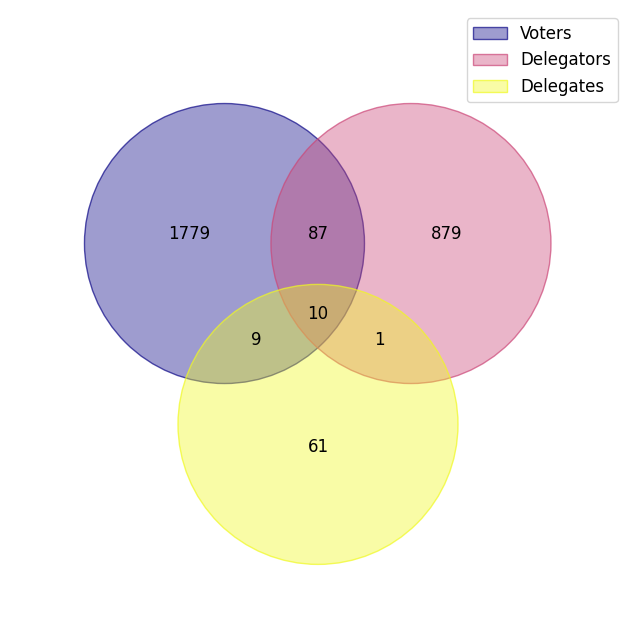

In [27]:
subsets = {
    # "Proposers": proposers,
    "Voters": voters,
    # "Delegators": delegators,
    # "Delegates": delegates
    "Delegators": from_delegations_without_same_to,
    "Delegates": to_delegations_without_same_from
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

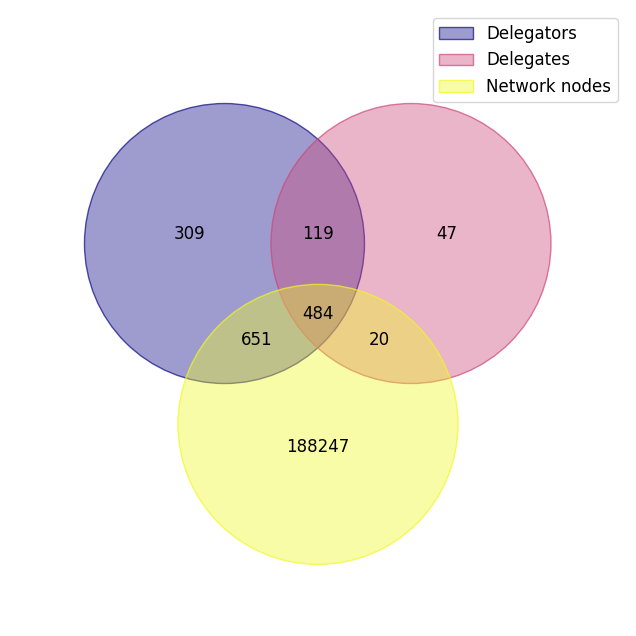

In [29]:
subsets = {
    # "Proposers": v2_proposers | v3_proposers,
    # "Voters": v2_voters | v3_voters,
    # "Delegations": delegators | delegates,
    "Delegators": delegators,
    "Delegates": delegates,
    "Network nodes": set(G_aave_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

## Degree distribution

In [77]:
def plot_degree_distribution(nodeset, G, name):
    degrees = dict(G.degree())
    nodeset_degrees = [degrees[node] for node in nodeset]
    
    plt.figure(figsize=(10, 6))
    plt.hist(nodeset_degrees, bins=np.logspace(np.log10(1), np.log10(max(nodeset_degrees)), 50), alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(f'{name} nodes degree distribution')
    plt.show()

In [ ]:
plot_degree_distribution(proposers, G_aave, 'Proposer')
plot_degree_distribution(voters, G_aave, 'Voter')
plot_degree_distribution(all_delegations, G_aave, 'Delegation')
plot_degree_distribution(non_governance_users, G_aave, 'Non-governance')

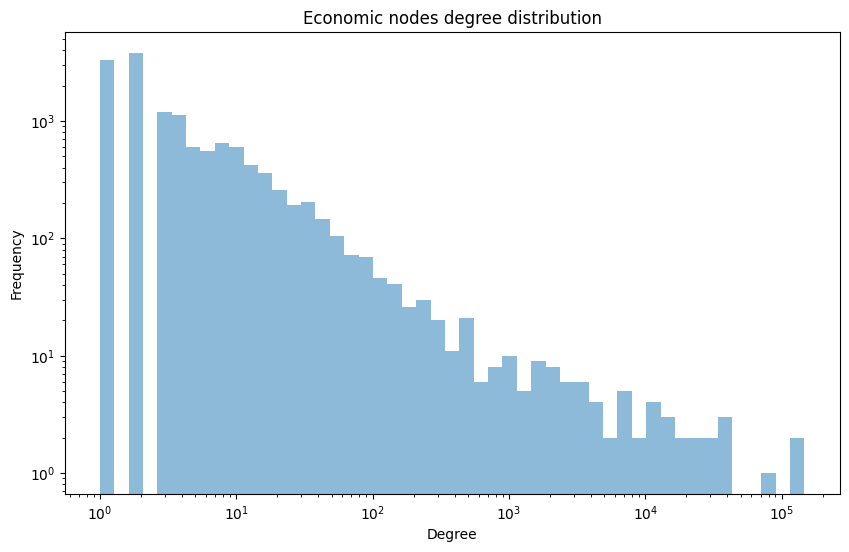

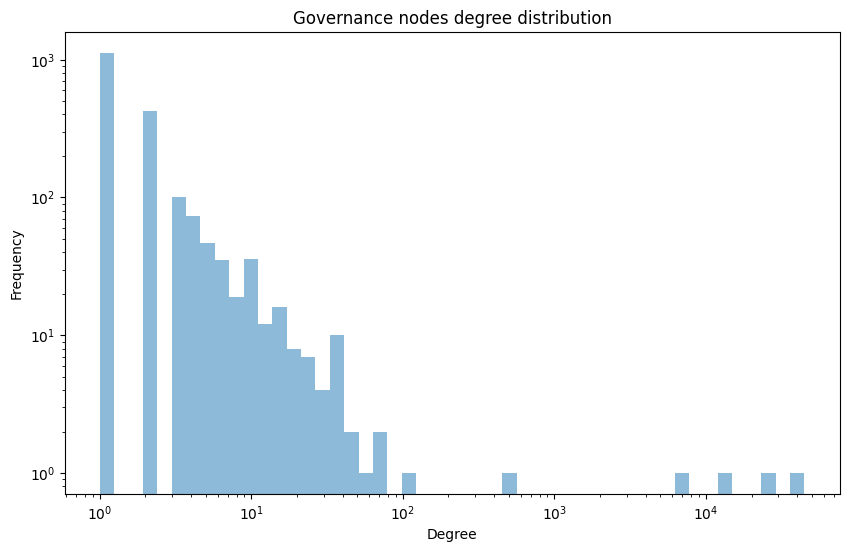

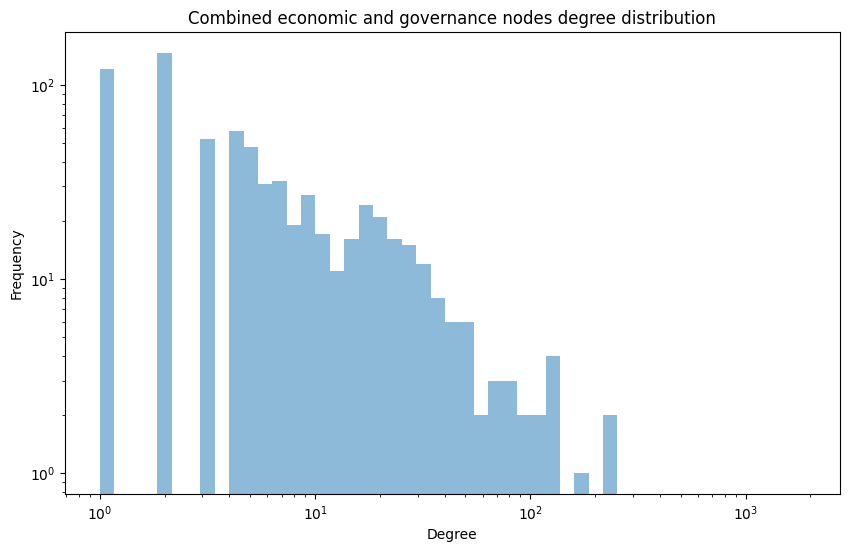

In [78]:
plot_degree_distribution(only_economic_users, G_aave, 'Economic')
plot_degree_distribution(only_governance_users, G_aave, 'Governance')
plot_degree_distribution(both_economic_and_governance_users, G_aave, 'Combined economic and governance')

In [ ]:
def plot_in_out_degree_distribution(nodeset, G, name):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    
    nodeset_in_degrees = [in_degrees[node] for node in nodeset]
    nodeset_out_degrees = [out_degrees[node] for node in nodeset]
    
    plt.figure(figsize=(10, 6))
    plt.hist(nodeset_in_degrees, bins=np.logspace(np.log10(1), np.log10(max(nodeset_in_degrees)), 50), alpha=0.5, label='In-degree')
    plt.hist(nodeset_out_degrees, bins=np.logspace(np.log10(1), np.log10(max(nodeset_out_degrees)), 50), alpha=0.5, label='Out-degree')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(f'{name} nodes in- and out-degree distribution')
    plt.legend()
    plt.show()

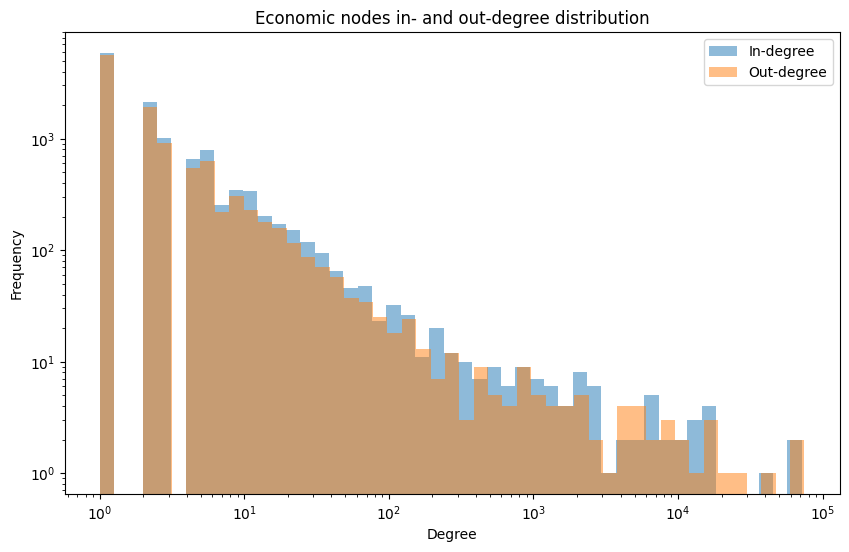

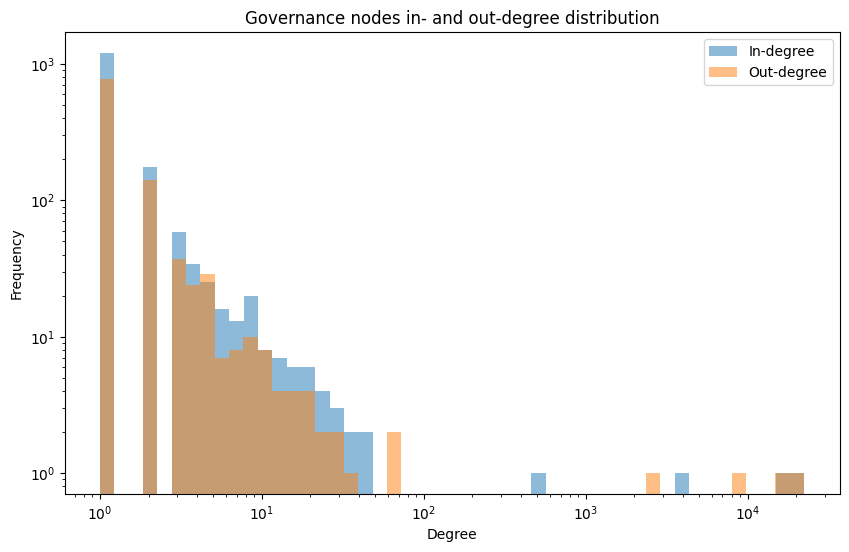

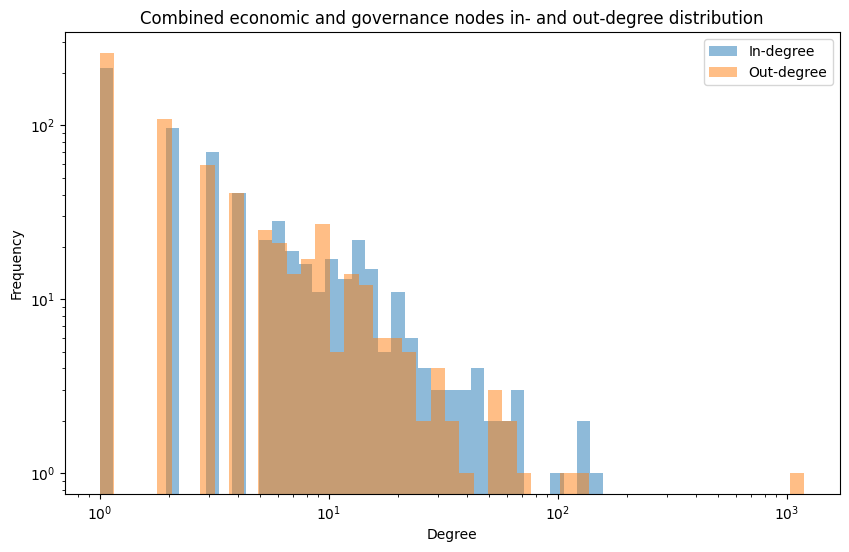

In [83]:
plot_in_out_degree_distribution(only_economic_users, G_aave, 'Economic')
plot_in_out_degree_distribution(only_governance_users, G_aave, 'Governance')
plot_in_out_degree_distribution(both_economic_and_governance_users, G_aave, 'Combined economic and governance')

## Assortativity coefficient

In [79]:
economic_ac = nx.degree_assortativity_coefficient(G_aave, weight='weight', nodes=only_economic_users)
governance_ac = nx.degree_assortativity_coefficient(G_aave, weight='weight', nodes=only_governance_users)
both_ac = nx.degree_assortativity_coefficient(G_aave, weight='weight', nodes=both_economic_and_governance_users)

print(economic_ac, governance_ac, both_ac)

1.0000000000000002 0.10184000023574859 -0.520334282127826


## Others

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G_aave, normalized=True, weight='weight')

# betweenness_centrality_values = {
#     'Proposers': {node: betweenness_centrality[node] for node in proposers},
#     'Voters': {node: betweenness_centrality[node] for node in voters},
#     'Delegations': {node: betweenness_centrality[node] for node in all_delegations},
#     'Non-governance': {node: betweenness_centrality[node] for node in non_governance_users}
# }

# for subset, values in betweenness_centrality_values.items():
#     plt.figure(figsize=(12, 8))
#     plt.hist(values.values(), bins=50, alpha=0.5, label=subset)
#     plt.xlabel('Betweenness Centrality')
#     plt.ylabel('Frequency')
#     plt.title(f'Betweenness Centrality Distribution for {subset}')
#     plt.legend()
#     plt.show()

In [60]:
scc = nx.strongly_connected_components(G_aave)

largest_scc = max(scc, key=len)
G_largest_scc = G_aave.subgraph(largest_scc).copy()

In [ ]:
num_nodes = G_largest_scc.number_of_nodes()
num_edges = G_largest_scc.number_of_edges()
density = nx.density(G_largest_scc)

percentage_nodes = (num_nodes / G_aave.number_of_nodes()) * 100
percentage_edges = (num_edges / G_aave.number_of_edges()) * 100

print(f'Number of nodes: {num_nodes}, {percentage_nodes:.2f}%')
print(f'Number of edges: {num_edges}, {percentage_edges:.2f}%')

Number of nodes: 83773, 44.23%
Number of edges: 3007979, 95.09%


In [ ]:
pearson_coefficients = {
    'Proposers': nx.degree_pearson_correlation_coefficient(G_aave, nodes=proposers),
    'Voters': nx.degree_pearson_correlation_coefficient(G_aave, nodes=voters),
    'Delegations': nx.degree_pearson_correlation_coefficient(G_aave, nodes=all_delegations),
    'Non-governance': nx.degree_pearson_correlation_coefficient(G_aave, nodes=non_governance_users)
}

## Importance (PageRank & degree centrality)

In [10]:
pagerank_scores = nx.pagerank(G_aave)
degree_centrality_scores = nx.degree_centrality(G_aave)

sorted_pagerank_scores = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_degree_centrality_scores = sorted(degree_centrality_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# top_pagerank_nodes = [(node, score, 'Proposers' if node in proposers else 'Voters' if node in voters else 'Delegations' if node in all_delegations else 'Non-governance') for node, score in sorted_pagerank_scores]
# top_degree_centrality_nodes = [(node, score, 'Proposers' if node in proposers else 'Voters' if node in voters else 'Delegations' if node in all_delegations else 'Non-governance') for node, score in sorted_degree_centrality_scores]
top_pagerank_nodes = [(node, score, 'Economic' if node in only_economic_users else 'Governance' if node in only_governance_users else 'Both' if node in both_economic_and_governance_users else 'None') for node, score in sorted_pagerank_scores]
top_degree_centrality_nodes = [(node, score, 'Economic' if node in only_economic_users else 'Governance' if node in only_governance_users else 'Both' if node in both_economic_and_governance_users else 'None') for node, score in sorted_degree_centrality_scores]

print("Top 10 PageRank Scores:")
for node, score, subset in top_pagerank_nodes:
    print(f"Node: {node}, Score: {score}, Subset: {subset}")

print("\nTop 10 degree centrality scores:")
for node, score, subset in top_degree_centrality_nodes:
    print(f"Node: {node}, Score: {score}, Subset: {subset}")

Top 10 PageRank Scores:
Node: 0x28c6c06298d514db089934071355e5743bf21d60, Score: 0.04223130085240229, Subset: None
Node: 0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb, Score: 0.021188736621505944, Subset: None
Node: 0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43, Score: 0.020374309832705894, Subset: Economic
Node: 0x51c72848c68a965f66fa7a88855f9f7784502a7f, Score: 0.020090937798030367, Subset: None
Node: 0xb33bd56d4192e8e4e6a02e93eabc732165199346, Score: 0.015501419191149475, Subset: None
Node: 0x2aceda63b5e958c45bd27d916ba701bc1dc08f7a, Score: 0.014685274178441836, Subset: None
Node: 0xdef171fe48cf0115b1d80b88dc8eab59176fee57, Score: 0.013309701924207232, Subset: Economic
Node: 0xa69babef1ca67a37ffaf7a485dfff3382056e78c, Score: 0.01304661012499228, Subset: None
Node: 0xa9077cdb3d13f45b8b9d87c43e11bce0e73d8631, Score: 0.011336509949706017, Subset: None
Node: 0xc697051d1c6296c24ae3bcef39aca743861d9a81, Score: 0.011057354982723594, Subset: Governance

Top 10 degree centrality scores:
Node: 0x44

In [16]:
degree_centrality_values = {
    'Economic': [degree_centrality_scores[node] for node in only_economic_users],
    'Governance': [degree_centrality_scores[node] for node in only_governance_users],
    'Both': [degree_centrality_scores[node] for node in both_economic_and_governance_users]
}

pagerank_values = {
    'Economic': [pagerank_scores[node] for node in only_economic_users],
    'Governance': [pagerank_scores[node] for node in only_governance_users],
    'Both': [pagerank_scores[node] for node in both_economic_and_governance_users]
}

# for subset, values in degree_centrality_values.items():
#     plt.figure(figsize=(12, 8))
#     plt.hist(values, bins=50, alpha=0.5, label=subset)
#     plt.xlabel('Degree Centrality')
#     plt.ylabel('Frequency')
#     plt.title(f'Degree Centrality Distribution for {subset}')
#     plt.legend()
#     plt.show()

# for subset, values in pagerank_values.items():
#     plt.figure(figsize=(12, 8))
#     plt.hist(values, bins=50, alpha=0.5, label=subset)
#     plt.xlabel('Pagerank')
#     plt.ylabel('Frequency')
#     plt.title(f'Pagerank Distribution for {subset}')
#     plt.legend()
#     plt.show()

def get_top_nodes(scores, subset, top_n=10):
    subset_scores = {node: scores[node] for node in subset}
    sorted_subset_scores = sorted(subset_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_subset_scores

top_10_degree_centrality = {
    'Economic': get_top_nodes(degree_centrality_scores, only_economic_users),
    'Governance': get_top_nodes(degree_centrality_scores, only_governance_users),
    'Both': get_top_nodes(degree_centrality_scores, both_economic_and_governance_users)
}

top_10_pagerank = {
    'Economic': get_top_nodes(pagerank_scores, only_economic_users),
    'Governance': get_top_nodes(pagerank_scores, only_governance_users),
    'Both': get_top_nodes(pagerank_scores, both_economic_and_governance_users)
}

print("Top 10 Degree Centrality Nodes:")
for subset, nodes in top_10_degree_centrality.items():
    print(f"\n{subset}:")
    for node, score in nodes:
        print(f"Node: {node}, Score: {score}")

print("\nTop 10 Pagerank Nodes:")
for subset, nodes in top_10_pagerank.items():
    print(f"\n{subset}:")
    for node, score in nodes:
        print(f"Node: {node}, Score: {score}")

Top 10 Degree Centrality Nodes:

Economic:
Node: 0xdef171fe48cf0115b1d80b88dc8eab59176fee57, Score: 0.7735650814937619
Node: 0xba12222222228d8ba445958a75a0704d566bf2c8, Score: 0.7638027254343959
Node: 0xf081470f5c6fbccf48cc4e5b82dd926409dcdd67, Score: 0.42879393456211956
Node: 0xe37e799d5077682fa0a244d46e5649f71457bd09, Score: 0.213272369206076
Node: 0xdb6f1920a889355780af7570773609bd8cb1f498, Score: 0.20967682324802933
Node: 0x3cf7a3399439e3c10e2ea7e01272b54a66a04ba6, Score: 0.18514157792197508
Node: 0xec7be89e9d109e7e3fec59c222cf297125fefda2, Score: 0.17920707916008893
Node: 0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43, Score: 0.14849446412637737
Node: 0xc36442b4a4522e871399cd717abdd847ab11fe88, Score: 0.13778702329977138
Node: 0x9008d19f58aabd9ed0d60971565aa8510560ab41, Score: 0.12177338028838286

Governance:
Node: 0xc697051d1c6296c24ae3bcef39aca743861d9a81, Score: 0.23550562035047334
Node: 0x4da27a545c0c5b758a6ba100e3a049001de870f5, Score: 0.1367838606976732
Node: 0x25f2226b597e8f951

In [ ]:
# degree_centrality_values = {
#     'Proposers': [degree_centrality_values['Proposers'][node] for node in proposers],
#     'Voters': [degree_centrality_values['Voters'][node] for node in voters],
#     'Delegations': [degree_centrality_values['Delegations'][node] for node in all_delegations],
#     'Non-governance': [degree_centrality_values['Non-governance'][node] for node in non_governance_users]
# }

# pagerank_values = {
#     'Proposers': [pagerank_values['Proposers'][node] for node in proposers],
#     'Voters': [pagerank_values['Voters'][node] for node in voters],
#     'Delegations': [pagerank_values['Delegations'][node] for node in all_delegations],
#     'Non-governance': [pagerank_values['Non-governance'][node] for node in non_governance_users]
# }

for subset, values in degree_centrality_values.items():
    plt.figure(figsize=(12, 8))
    plt.hist(values, bins=50, alpha=0.5, label=subset)
    plt.xlabel('Degree centrality')
    plt.ylabel('Frequency')
    plt.title(f'Degree centrality distribution for {subset}')
    plt.legend()
    plt.show()

for subset, values in pagerank_values.items():
    plt.figure(figsize=(12, 8))
    plt.hist(values, bins=50, alpha=0.5, label=subset)
    plt.xlabel('Pagerank')
    plt.ylabel('Frequency')
    plt.title(f'Pagerank distribution for {subset}')
    plt.legend()
    plt.show()

## Community detection

In [63]:
comp = nx.community.girvan_newman(G_aave)
# tuple(c for c in next(comp))

In [ ]:
def calculate_leiden_partition(G, directed=False, weighted=False):
    if directed:
        G_igraph = ig.Graph(directed=True, multiple=True)
    else:
        G_igraph = ig.Graph(directed=False, multiple=True)
    
    if weighted:
        G_igraph.add_vertices(list(G.nodes()))
        G_igraph.add_edges([(u, v) for u, v, _ in G.edges(keys=True)])
        weights = [data['weight'] for _, _, _, data in G.edges(keys=True, data=True)]
        partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights=weights)
    else:
        G_igraph.add_vertices(list(G.nodes()))
        G_igraph.add_edges([(u, v) for u, v, _ in G.edges(keys=True)])
        partition = la.find_partition(G_igraph, la.ModularityVertexPartition)
    
    modularity_score = partition.modularity
    return partition, modularity_score

partition_weighted_directed, modularity_unweighted_directed = calculate_leiden_partition(G_aave, directed=True, weighted=True)
print(f'Weighted & directed: {len(partition_weighted_directed)}, {modularity_unweighted_directed}')

partition_weighted_undirected, modularity_weighted_undirected = calculate_leiden_partition(G_aave, directed=False, weighted=True)
print(f'Weighted & undirected: {len(partition_weighted_undirected)}, {modularity_weighted_undirected}')

partition_unweighted_directed, modularity_unweighted_directed = calculate_leiden_partition(G_aave, directed=True, weighted=False)
print(f'Unweighted & directed: {len(partition_unweighted_directed)}, {modularity_unweighted_directed}')

partition_unweighted_undirected, modularity_unweighted_undirected = calculate_leiden_partition(G_aave, directed=False, weighted=False)
print(f'Unweighted & undirected: {len(partition_unweighted_undirected)}, {modularity_unweighted_undirected}')

Weighted & directed: 189402, -0.011219099254883706
Unweighted & directed: 6134, 0.5554958007733756
Undirected & weighted: 189402, -0.011711631005413349
Unweighted & undirected: 6136, 0.5548753352782865


In [13]:
def calculate_louvain_partition(G, directed=False, weighted=False):
    if directed:
        G_temp = G
        
        # if weighted:
        #     partition = nx.community.louvain_communities(G_temp, weight='weight')
        # else:
        #     partition = nx.community.louvain_communities(G_temp, weight=None)
        
    else:
        G_temp = nx.MultiGraph()
        
        if weighted:
            G_temp.add_nodes_from(G.nodes())
            G_temp.add_edges_from(G.edges(data=True))
            # partition = nx.community.louvain_communities(G_temp, weight='weight')
        else:
            G_temp.add_nodes_from(G.nodes())
            G_temp.add_edges_from(G.edges())
            # partition = nx.community.louvain_communities(G_temp, weight=None)
    
    
    if weighted:
        partition = nx.community.louvain_communities(G_temp, weight='weight')
        modularity_score = nx.community.modularity(G_temp, partition, weight='weight')
    else:
        partition = nx.community.louvain_communities(G_temp, weight=None)
        modularity_score = nx.community.modularity(G_temp, partition, weight=None)
    # if weighted:
    #     G_temp.add_nodes_from(G.nodes())
    #     G_temp.add_edges_from(G.edges(data=True))
    #     partition = nx.community.louvain_communities(G_temp, weight='weight')
    # else:
    #     G_temp.add_nodes_from(G.nodes())
    #     G_temp.add_edges_from(G.edges())
    #     partition = nx.community.louvain_communities(G_temp, weight=None)
    
    # modularity_score = nx.community.modularity(G_temp, partition)
    return partition, modularity_score

partition_weighted_directed, modularity_weighted_directed = calculate_louvain_partition(G_aave, directed=True, weighted=True)
print(f'Weighted & directed: {len(partition_weighted_directed)}, {modularity_weighted_directed}')

partition_unweighted_directed, modularity_unweighted_directed = calculate_louvain_partition(G_aave, directed=True, weighted=False)
print(f'Unweighted & directed: {len(partition_unweighted_directed)}, {modularity_unweighted_directed}')

partition_weighted_undirected, modularity_weighted_undirected = calculate_louvain_partition(G_aave, directed=False, weighted=True)
print(f'Weighted & undirected: {len(partition_weighted_undirected)}, {modularity_weighted_undirected}')

partition_unweighted_undirected, modularity_unweighted_undirected = calculate_louvain_partition(G_aave, directed=False, weighted=False)
print(f'Unweighted & undirected: {len(partition_unweighted_undirected)}, {modularity_unweighted_undirected}')

Weighted & directed: 18266, 0.875
Unweighted & directed: 6087, 0.5508127035611811
Weighted & undirected: 15700, 0.875
Unweighted & undirected: 6115, 0.5492381075349299


In [17]:
partition = nx.community.louvain_communities(G_aave, weight='weight')

sorted_communities = sorted(partition, key=lambda x: len(x), reverse=True)

print(f'Number of communities: {len(sorted_communities)}, modularity score: {nx.community.modularity(G_aave, partition)}')

Number of communities: 18185, modularity score: 0.875


In [55]:
# partition = nx.community.louvain_communities(G_aave_undirected, weight='weight')

# sorted_communities = sorted(partition, key=lambda x: len(x), reverse=True)

print(f'Number of communities: {len(sorted_communities)}, modularity score: {nx.community.modularity(G_aave_undirected, partition)}')

Number of communities: 15711, modularity score: 0.875


In [ ]:
# transfers_df['date'] = pd.to_datetime(transfers_df['timestamp'], unit='s').dt.date

# transfers_by_date = transfers_df.groupby('date')

modularity_scores = {}
gc_ratio = {}

for date, group in transfers_by_date:
    G_temp = nx.MultiDiGraph()
    for _, row in group.iterrows():
        G_temp.add_edge(row['from'].lower(), row['to'].lower(), key=row['timestamp'])#, weight=row['value'])
    
    if len(G_temp.nodes()) > 0:
        # Number of components, giant component size ratio
        partition = nx.community.louvain_communities(G_temp)#, weight='weight')
        size_largest = len(max(partition, key=len))
        modularity_score = nx.community.modularity(G_temp, partition)
        # nr_components = nx.number_connected_components(G_temp)
        gc_size = size_largest/len(G_temp.nodes())
        print(f'Date: {date}, modularity: {modularity_score}, giant component size ratio: {gc_size}')
        modularity_scores[date] = modularity_score
        gc_ratio[date] = gc_size

dates = list(modularity_scores.keys())
scores = list(modularity_scores.values())

plt.figure(figsize=(12, 6))
plt.plot(dates, scores)
plt.xlabel('Date')
plt.ylabel('Modularity Score')
plt.title('Modularity Score per Day')
plt.xticks(rotation=90)
plt.show()

In [44]:
total_count = 0
first_n_count = 0
index = 0
n = 10

for p in sorted_communities:
    if index < n:
        first_n_count += len(p)
    index += 1
    total_count += len(p)
    
print(first_n_count, total_count, first_n_count/total_count)

114804 189402 0.6061393227104255


In [54]:
for node, score, subset in top_pagerank_nodes:
    community_count = 0
    for p in sorted_communities:
        if node in p:
            print(f'Node: {node}, subset: {subset}, community: {community_count}')
            break
        community_count += 1

Node: 0x28c6c06298d514db089934071355e5743bf21d60, subset: Both, community: 1
Node: 0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb, subset: Both, community: 2
Node: 0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43, subset: Economic, community: 4
Node: 0x51c72848c68a965f66fa7a88855f9f7784502a7f, subset: Both, community: 2
Node: 0xb33bd56d4192e8e4e6a02e93eabc732165199346, subset: Both, community: 0
Node: 0x2aceda63b5e958c45bd27d916ba701bc1dc08f7a, subset: Both, community: 0
Node: 0xdef171fe48cf0115b1d80b88dc8eab59176fee57, subset: Economic, community: 3
Node: 0xa69babef1ca67a37ffaf7a485dfff3382056e78c, subset: Both, community: 8
Node: 0xa9077cdb3d13f45b8b9d87c43e11bce0e73d8631, subset: Both, community: 0
Node: 0xc697051d1c6296c24ae3bcef39aca743861d9a81, subset: Governance, community: 8


In [58]:
for node, score, subset in top_degree_centrality_nodes:
    community_count = 0
    for p in sorted_communities:
        if node in p:
            print(f'Node: {node}, subset: {subset}, community: {community_count}')
            break
        community_count += 1

Node: 0x44720a6f572649526ac9073cae9200755cc78e0a, subset: Both, community: 0
Node: 0xb33bd56d4192e8e4e6a02e93eabc732165199346, subset: Both, community: 0
Node: 0xa9077cdb3d13f45b8b9d87c43e11bce0e73d8631, subset: Both, community: 0
Node: 0x2aceda63b5e958c45bd27d916ba701bc1dc08f7a, subset: Both, community: 0
Node: 0x25fb97799f80433e422f47e75173314e54dae174, subset: Both, community: 0
Node: 0xa236278bec0e0677a48527340cfb567b4e6e9adc, subset: Both, community: 0
Node: 0x51c72848c68a965f66fa7a88855f9f7784502a7f, subset: Both, community: 2
Node: 0xdef171fe48cf0115b1d80b88dc8eab59176fee57, subset: Economic, community: 3
Node: 0xba12222222228d8ba445958a75a0704d566bf2c8, subset: Economic, community: 3
Node: 0xc42bf5cd16d9eb1e892b66bb32a3892dcb7bb75c, subset: Both, community: 0


In [15]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': []
}

for community in sorted_communities:
    economic_count = len(only_economic_users & community)
    governance_count = len(only_governance_users & community)
    both_count = len(both_economic_and_governance_users & community)
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)

In [17]:
print("Communities ordered by size (descending):")
for i, community in enumerate(sorted_communities):
    print(f"Community {i+1}: Size = {len(community)}")

Communities ordered by size (descending):
Community 1: Size = 35890
Community 2: Size = 16471
Community 3: Size = 15079
Community 4: Size = 13579
Community 5: Size = 8992
Community 6: Size = 7490
Community 7: Size = 5595
Community 8: Size = 4717
Community 9: Size = 3835
Community 10: Size = 3156
Community 11: Size = 3066
Community 12: Size = 2571
Community 13: Size = 2137
Community 14: Size = 2110
Community 15: Size = 2082
Community 16: Size = 2032
Community 17: Size = 1994
Community 18: Size = 1544
Community 19: Size = 1268
Community 20: Size = 1015
Community 21: Size = 1010
Community 22: Size = 947
Community 23: Size = 928
Community 24: Size = 809
Community 25: Size = 616
Community 26: Size = 540
Community 27: Size = 486
Community 28: Size = 441
Community 29: Size = 380
Community 30: Size = 326
Community 31: Size = 315
Community 32: Size = 308
Community 33: Size = 287
Community 34: Size = 268
Community 35: Size = 254
Community 36: Size = 243
Community 37: Size = 231
Community 38: Siz

In [18]:
print("\nDistribution of Economic and Governance nodes across communities:")
for i, (economic_count, governance_count, both_count) in enumerate(zip(community_distribution['Economic'], community_distribution['Governance'], community_distribution['Both'])):
    print(f"Community {i+1}: Economic = {economic_count}, Governance = {governance_count}, Both = {both_count}")


Distribution of Economic and Governance nodes across communities:
Community 1: Economic = 3181, Governance = 37, Both = 33
Community 2: Economic = 232, Governance = 299, Both = 25
Community 3: Economic = 745, Governance = 217, Both = 37
Community 4: Economic = 2493, Governance = 170, Both = 146
Community 5: Economic = 43, Governance = 7, Both = 1
Community 6: Economic = 751, Governance = 50, Both = 22
Community 7: Economic = 1045, Governance = 416, Both = 247
Community 8: Economic = 740, Governance = 6, Both = 6
Community 9: Economic = 375, Governance = 365, Both = 40
Community 10: Economic = 17, Governance = 6, Both = 1
Community 11: Economic = 1846, Governance = 4, Both = 45
Community 12: Economic = 12, Governance = 1, Both = 1
Community 13: Economic = 28, Governance = 14, Both = 1
Community 14: Economic = 15, Governance = 14, Both = 1
Community 15: Economic = 84, Governance = 27, Both = 4
Community 16: Economic = 2, Governance = 0, Both = 0
Community 17: Economic = 329, Governance 

In [45]:
top_communities = sorted_communities[:n]

community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': []
}

for community in top_communities:
    economic_count = len(only_economic_users & community)
    governance_count = len(only_governance_users & community)
    both_count = len(both_economic_and_governance_users & community)
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)

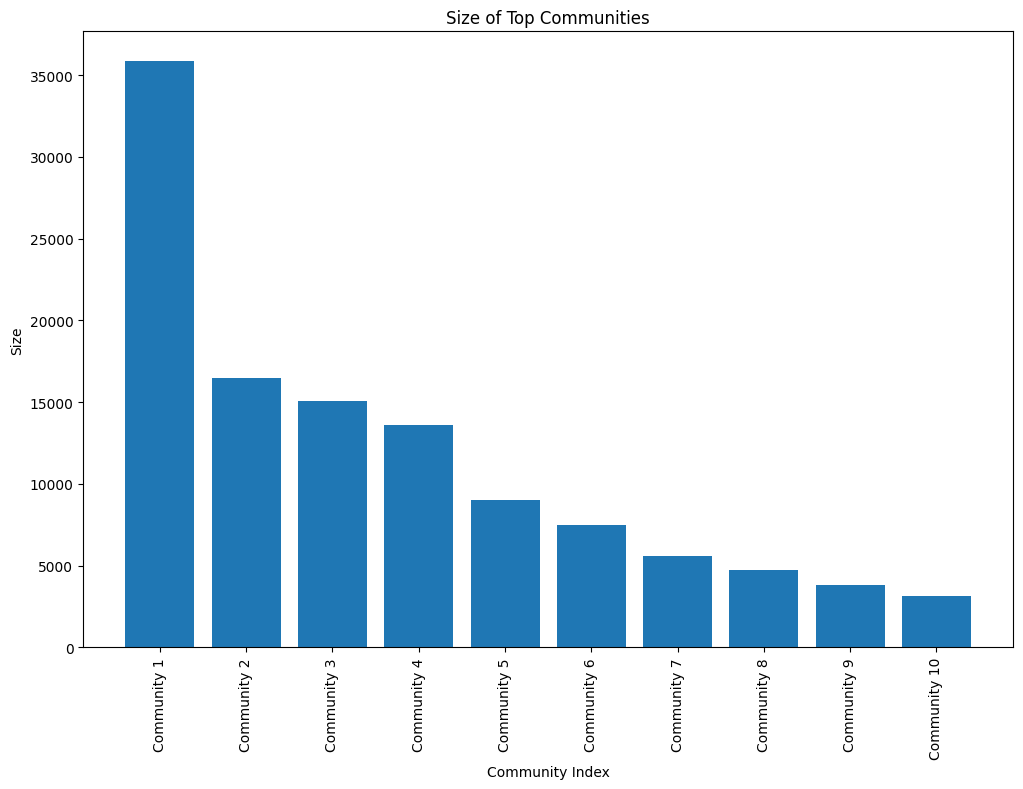

In [47]:
top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

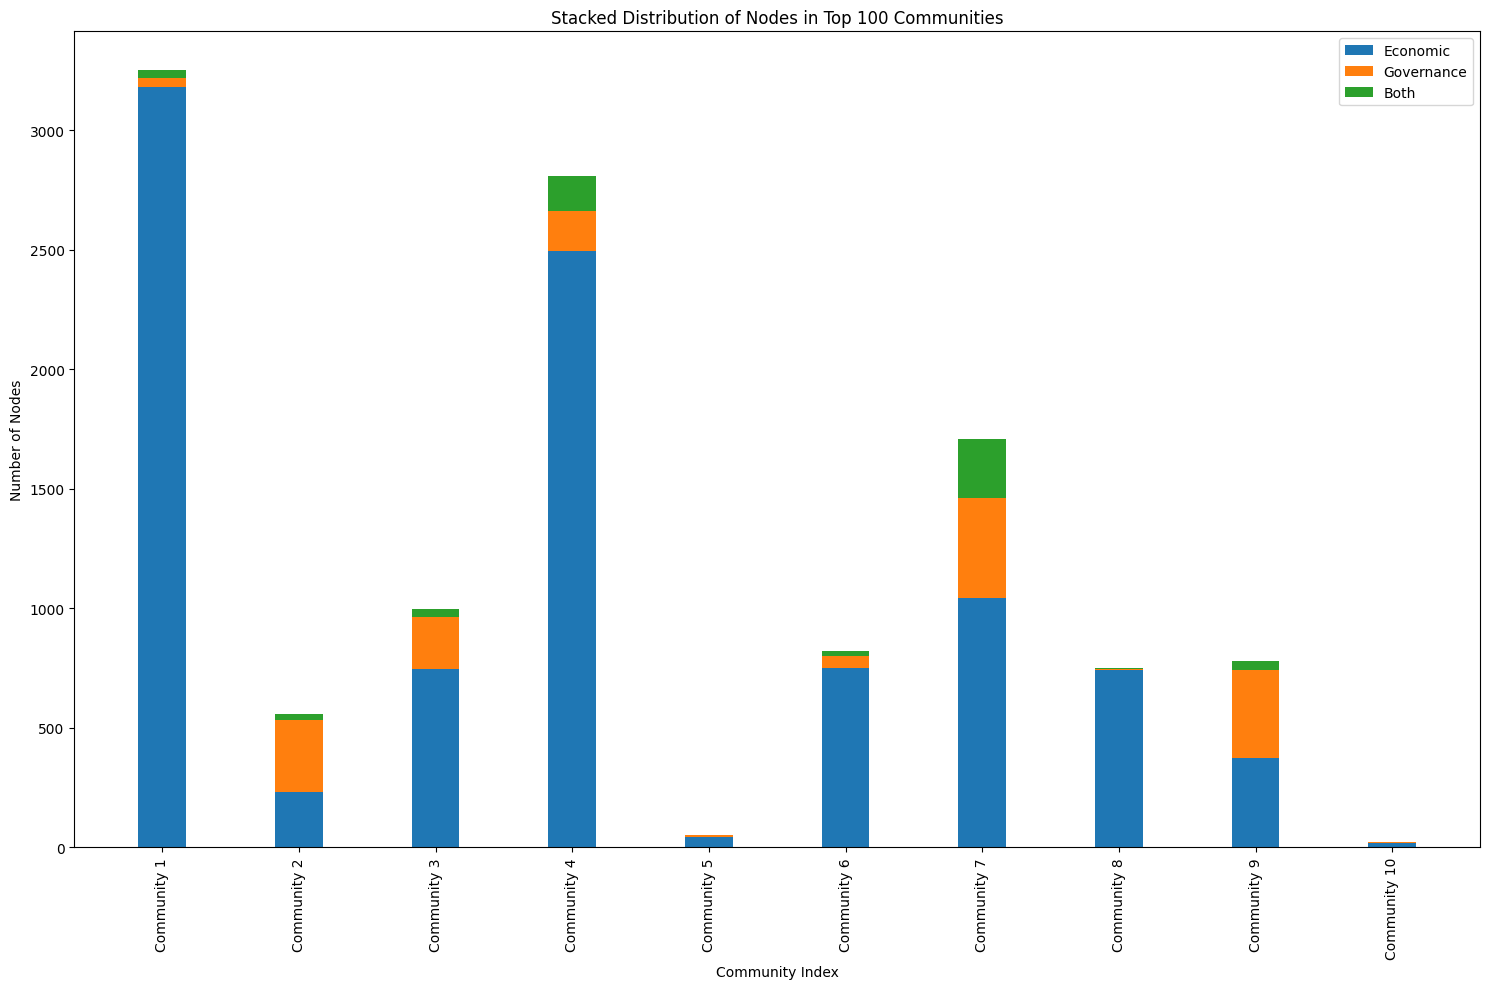

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

bar_width = 0.35
index = np.arange(len(top_communities))

bar1 = ax.bar(index, community_distribution['Economic'], bar_width, label='Economic')
bar2 = ax.bar(index, community_distribution['Governance'], bar_width, bottom=community_distribution['Economic'], label='Governance')
bar3 = ax.bar(index, community_distribution['Both'], bar_width, bottom=np.array(community_distribution['Economic']) + np.array(community_distribution['Governance']), label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in top 100 communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

## Monthly networks

In [ ]:
aave_df['date'] = pd.to_datetime(aave_df['date'])

aave_df['month'] = aave_df['date'].dt.to_period('M')
monthly_groups = aave_df.groupby('month')

def calculate_gini(graph):
    # degrees = np.array([deg for _, deg in graph.degree()])
    # if len(degrees) == 0:
    #     return 0
    
    # degrees = np.sort(degrees)
    # n = len(degrees)
    # index = np.arange(1, n + 1)
    
    # return (2 * np.sum(index * degrees) - (n + 1) * np.sum(degrees)) / (n * np.sum(degrees))
    
    graph = np.array(graph)
    if graph.size == 0:
        return 0
    graph = np.sort(graph)
    n = graph.size
    cumulative = np.cumsum(graph)
    return (2 * np.sum((np.arange(1, n+1) * graph)) - (n + 1) * cumulative[-1]) / (n * cumulative[-1])

def calculate_centralization(G):
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    centralization = sum(max_degree - degree for degree in degrees.values())
    return centralization / ((len(G.nodes()) - 1) * (len(G.nodes()) - 2))

months = []
degree_distributions = []
gini_coefficients = []
centralizations = []
assortativities = []

for month, group in monthly_groups:
    # G_month = nx.MultiDiGraph()
    G_month = nx.Graph()
    
    # for _, row in group.iterrows():
    #     G_month.add_edge(row['from'], row['to'], weight=row['value'])
    
    for _, row in group.iterrows():
        from_address = row['from'].lower()
        to_address = row['to'].lower()
        value = row['value']

        if G_month.has_edge(from_address, to_address):
            G_month[from_address][to_address]['weight'] += value
        else:
            G_month.add_edge(from_address, to_address, weight=value)
    
    # degrees = [degree for _, degree in G_month.degree()]
    
    part = nx.community.louvain_communities(G_month, weight='weight')

    print(month, len(part), nx.community.quality.modularity(G_month, part))
    
    # degree_distributions.append(degrees)
    # gini_coefficients.append(calculate_gini(G_month))
    ###
    # weights = [data['weight'] for _, _, data in G_month.edges(data=True) if 'weight' in data]
    # gini_coefficients.append(calculate_gini(weights))
    # centralizations.append(calculate_centralization(G_month))
    # assortativities.append(nx.degree_assortativity_coefficient(G_month))
    
    months.append(str(month))

# plt.figure(figsize=(12, 6))
# for i, degrees in enumerate(degree_distributions):
#     plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), alpha=0.5, label=months[i])
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Degree')
# plt.ylabel('Frequency')
# plt.title('Degree distribution over time')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, gini_coefficients, label='Gini coefficient')
plt.xlabel('Month')
plt.ylabel('Gini coefficient')
plt.title('Gini coefficient over time')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(months, centralizations, label='Centralization')
# plt.xlabel('Month')
# plt.ylabel('Centralization')
# plt.title('Centralization over time')
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(months, assortativities, label='Assortativity')
# plt.xlabel('Month')
# plt.ylabel('Assortativity')
# plt.title('Assortativity over time')
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()

In [ ]:
aave_df['date'] = pd.to_datetime(aave_df['date'])
aave_df['month'] = aave_df['date'].dt.to_period('M')
monthly_groups = aave_df.groupby('month')

months = []
num_nodes = []
num_edges = []
densities = []
assortativities = []

def calculate_network_features(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    return num_nodes, num_edges, density

for month, group in monthly_groups:
    G_month = nx.MultiDiGraph()
    
    for _, row in group.iterrows():
        G_month.add_edge(row['from'], row['to'], weight=row['value'])
        
    nx.degree_pearson_correlation_coefficient(G_month, weight='weight')
    
    # n_nodes, n_edges, density = calculate_network_features(G_month)
    
    # months.append(str(month))
    # num_nodes.append(n_nodes)
    # num_edges.append(n_edges)
    # densities.append(density)

# plt.plot(months, num_nodes, label='Number of nodes')
# plt.xlabel('Month')
# plt.ylabel('Value')
# plt.title('Number of nodes over time')
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(months, num_edges, label='Number of edges')
# plt.xlabel('Month')
# plt.ylabel('Value')
# plt.title('Number of edges over time')
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(months, densities, label='Density')
# plt.xlabel('Month')
# plt.ylabel('Value')
# plt.title('Density over time')
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, densities, label='Density')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Density over time')
plt.legend()
plt.xticks(rotation=90)
plt.show()

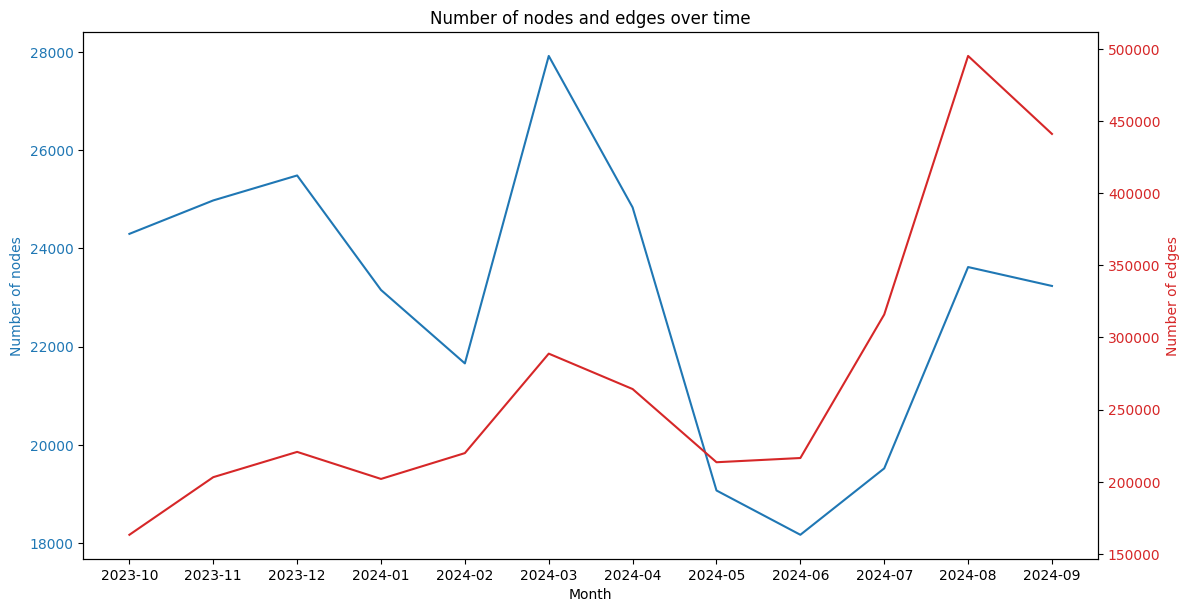

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of nodes', color=color)
ax1.plot(months, num_nodes, label='Number of nodes', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Number of edges', color=color)
ax2.plot(months, num_edges, label='Number of edges', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Number of nodes and edges over time')
plt.xticks(rotation=90)
plt.show()